# Modeling and Evaluation -- Tree Based Model
 - glmnet
 - rpart
 - randomforest
 - xgboost
 - grid search

# Import data

In [1]:
loan <- read.csv("loan.csv", stringsAsFactors = F)
loanT <- loan

# feature engineering


 - exclude some column

In [2]:
loan <- loan[, -which(colnames(loan) %in% c('id', 'member_id', 'url'))]

In [3]:
loan$home_ownership <- ifelse(loan$home_ownership %in% c('ANY', 'NONE', 'OTHER'), 'OTHER',
                              loan$home_ownership)

In [4]:
loan$dti <- ifelse(!is.na(loan$dti_joint), loan$dti_joint, loan$dti)

In [5]:
loan$annual_inc <- ifelse(!is.na(loan$annual_inc_joint), loan$annual_inc_joint, loan$annual_inc)

In [6]:
int_state <- by(loan, loan$addr_state, function(x) {
  return(mean(x$int_rate))
})
loan$state_mean_int <-
  ifelse(loan$addr_state %in% names(int_state)[which(int_state <= quantile(int_state, 0.25))], 
         'low', ifelse(loan$addr_state %in% names(int_state)[which(int_state <= quantile(int_state, 0.5))],
                       'lowmedium', ifelse(loan$addr_state %in% names(int_state)[which(int_state <= quantile(int_state, 0.75))], 
                                           'mediumhigh', 'high')))

 - missing data

In [7]:
num.NA <- sort(sapply(loan, function(x) { sum(is.na(x))} ), decreasing = TRUE)
remain.col <- names(num.NA)[which(num.NA <= 0.8 * dim(loan)[1])]
loan <- loan[, remain.col]

In [8]:
num.NA <- sort(sapply(loan, function(x) { sum(is.na(x))} ), decreasing = TRUE)
for(col.i in names(num.NA)[which(num.NA > 0)]) {
  loan[which(is.na(loan[, col.i])), col.i] <- median(loan[, col.i], na.rm = T)
}

split data into training data and testing data

In [9]:
set.seed(1)
train.ind <- sample(1:dim(loan)[1], 0.7 * dim(loan)[1])
train <- loan[train.ind, ]
test <- loan[-train.ind, ]

features which will be used in our model

In [10]:
train.sub <- train[, c('int_rate', 'state_mean_int', 'home_ownership', 'annual_inc', 'dti',
                       'term', 'loan_amnt', 'total_acc', 'tot_cur_bal', 'open_acc')]

# glmnet

In [11]:
library(glmnet)
#refer to stanford glmnet
# glmnet only takes matrix, can use is.data.frame() or is.matrix() to test
# glmnet standardizes every feature, even categorical feature
# http://stackoverflow.com/questions/17887747/how-does-glmnets-standardize-argument-handle-dummy-variables


Loading required package: Matrix
Loading required package: foreach
Loaded glmnet 2.0-13



In [12]:
ind = train.sub[, -1]
ind <- model.matrix( ~., ind)
dep <- train.sub[, 1]
fit <- glmnet(x=ind, y=dep) # default is alpha = 1, lasso

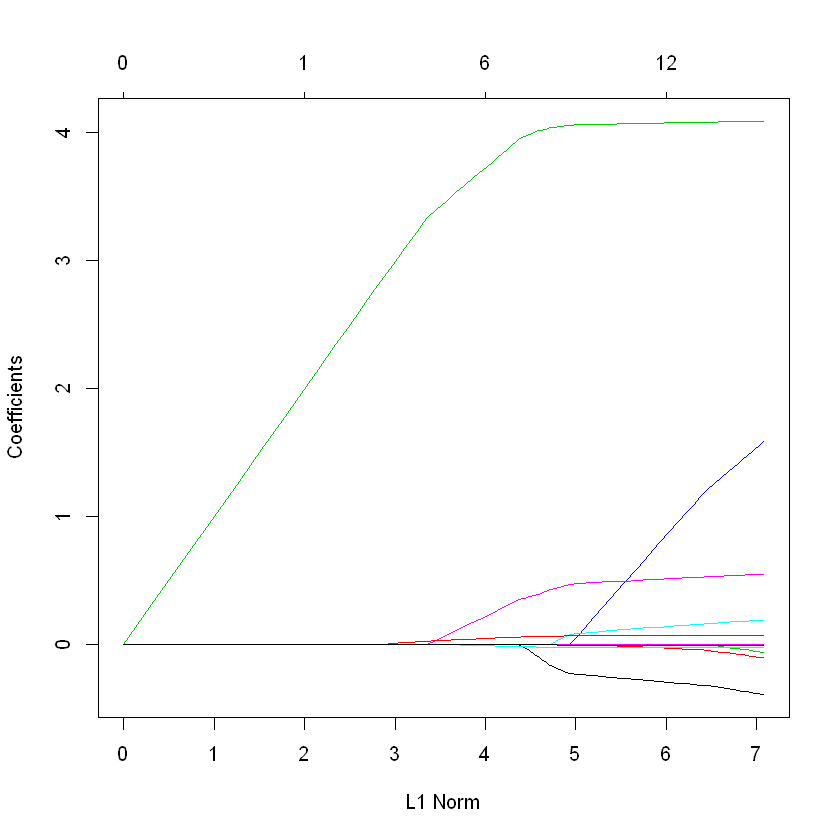

In [13]:
plot(fit)

# Understand the plot
 - The top row indicates the number of nonzero coefficients at the current Î», which is the effective degrees of freedom (df) for the lasso.
 - y axis is the value of coefficient
 - x axis is the sum of absolute value of coefficients (L1 norm), or log(lambda)

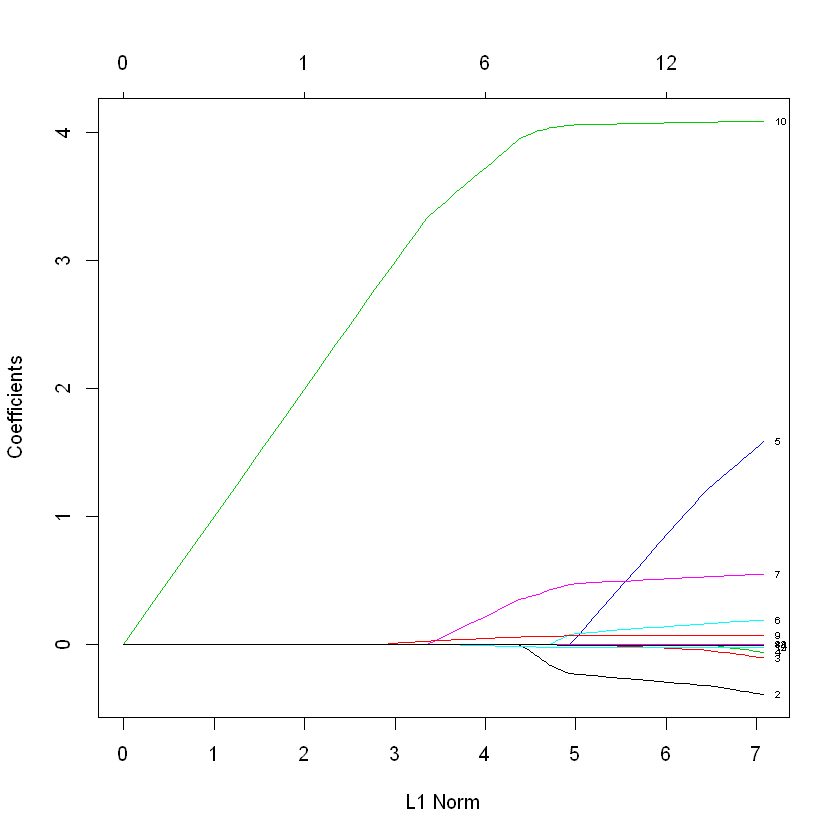

In [14]:
plot(fit, label = T)#add label to the l1 norm plot

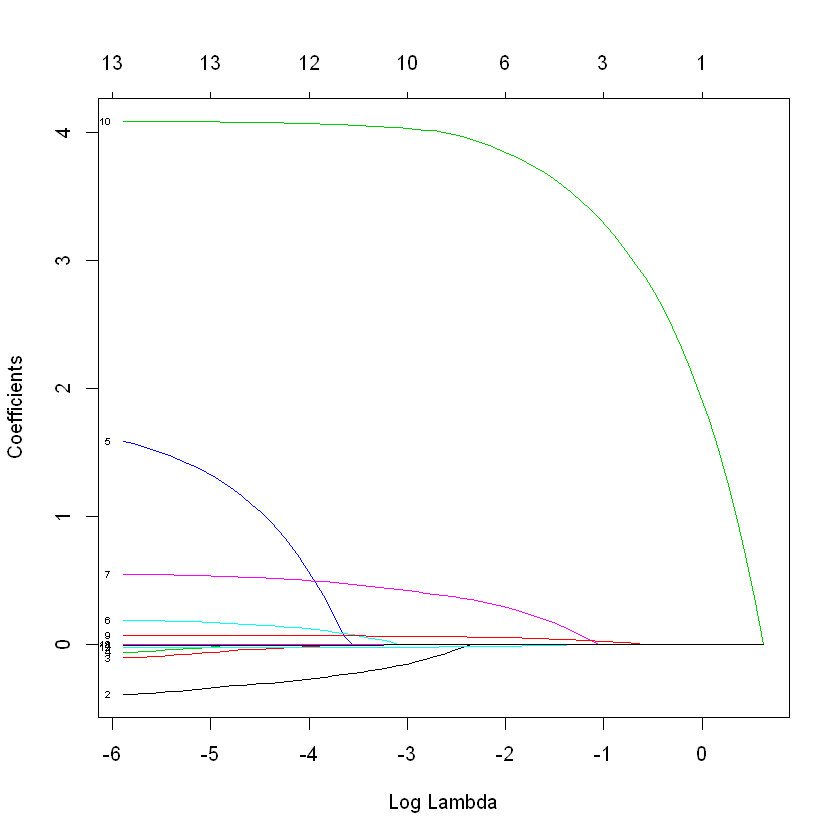

In [15]:
plot(fit, xvar = "lambda", label = T)

In [16]:
vnat=coef(fit) # why do we see two intercepts, one is from model.matrix, one is default added in glmnet

In [17]:
vnat

   [[ suppressing 71 column names 's0', 's1', 's2' ... ]]


15 x 71 sparse Matrix of class "dgCMatrix"
                                                                            
(Intercept)              13.24375 13.1347233 13.0353867 12.9448750 12.862404
(Intercept)               .        .          .          .          .       
state_mean_intlow         .        .          .          .          .       
state_mean_intlowmedium   .        .          .          .          .       
state_mean_intmediumhigh  .        .          .          .          .       
home_ownershipOTHER       .        .          .          .          .       
home_ownershipOWN         .        .          .          .          .       
home_ownershipRENT        .        .          .          .          .       
annual_inc                .        .          .          .          .       
dti                       .        .          .          .          .       
term 60 months            .        0.3637972  0.6952757  0.9973065  1.272506
loan_amnt                 .      

In [18]:
vnat <- vnat[-c(1,2), ncol(vnat)] # remove the intercept, and get the coefficients at the end of the path

In [19]:
vnat

state_mean_intlow  state_mean_intlowmedium state_mean_intmediumhigh 
           -3.938849e-01            -1.063454e-01            -6.405433e-02 
     home_ownershipOTHER        home_ownershipOWN       home_ownershipRENT 
            1.585478e+00             1.891995e-01             5.488875e-01 
              annual_inc                      dti           term 60 months 
           -1.891115e-06             6.841099e-02             4.088590e+00 
               loan_amnt                total_acc              tot_cur_bal 
            1.314701e-05            -2.418562e-02            -2.201560e-06 
                open_acc 
           -1.248490e-02

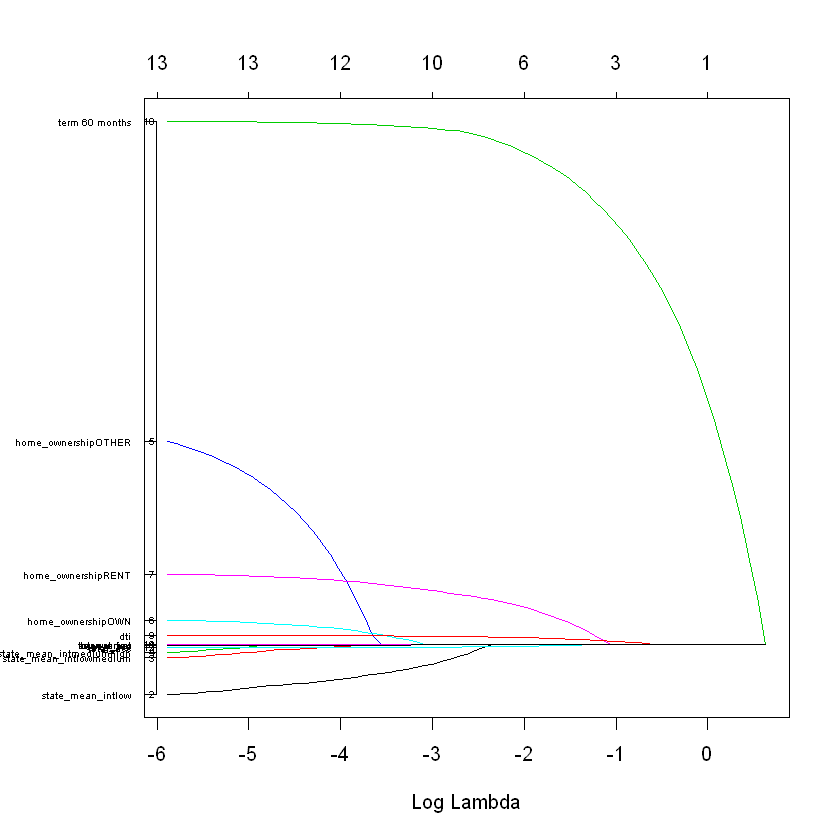

In [20]:
# default is par(mar=c(5.1,4.1,4.1,2.1), bottom, lef, top, right
par(mar = c(5.1,6,4.1,2.1))#change the margin of the chart
plot(fit, xvar = 'lambda', label = T, yaxt='n', ylab = "")
axis(2, at=vnat,line=-.5,label = colnames(ind)[-1],las=1, cex.axis=0.5)

In [21]:
print(fit)
# Df is the non zero beta, 
# saturated model is a model with a parameter for every observation so that the data are fitted exactly.
# Deviance_model = 2*(loglikelihood_saturate_model - loglikelihood_current_model)
# Deviance_null = 2*(loglikelihood_saturate_model - loglikelihood_intercept_only_model)
# Deviance percentage = 1 -  Deviance_model / Deviance_null
# lambda value


Call:  glmnet(x = ind, y = dep) 

      Df    %Dev   Lambda
 [1,]  0 0.00000 1.876000
 [2,]  1 0.03111 1.709000
 [3,]  1 0.05694 1.558000
 [4,]  1 0.07838 1.419000
 [5,]  1 0.09618 1.293000
 [6,]  1 0.11100 1.178000
 [7,]  1 0.12320 1.074000
 [8,]  1 0.13340 0.978200
 [9,]  1 0.14190 0.891300
[10,]  1 0.14890 0.812100
[11,]  1 0.15470 0.739900
[12,]  1 0.15960 0.674200
[13,]  1 0.16360 0.614300
[14,]  2 0.16760 0.559700
[15,]  3 0.17300 0.510000
[16,]  3 0.18000 0.464700
[17,]  3 0.18580 0.423400
[18,]  3 0.19060 0.385800
[19,]  3 0.19460 0.351500
[20,]  4 0.19820 0.320300
[21,]  5 0.20200 0.291800
[22,]  5 0.20540 0.265900
[23,]  5 0.20820 0.242300
[24,]  5 0.21050 0.220800
[25,]  6 0.21250 0.201200
[26,]  6 0.21420 0.183300
[27,]  6 0.21560 0.167000
[28,]  6 0.21670 0.152200
[29,]  6 0.21770 0.138700
[30,]  6 0.21850 0.126300
[31,]  6 0.21910 0.115100
[32,]  6 0.21970 0.104900
[33,]  6 0.22010 0.095570
[34,]  7 0.22060 0.087080
[35,]  7 0.22100 0.079340
[36,]  7 0.22130 0.072290
[37

In [22]:
coef(fit, s = 1/exp(2)) # s stands for lambda, calculate the coefficient given lambda = 1/exp(2)

15 x 1 sparse Matrix of class "dgCMatrix"
                                     1
(Intercept)               1.174455e+01
(Intercept)               .           
state_mean_intlow         .           
state_mean_intlowmedium   .           
state_mean_intmediumhigh  .           
home_ownershipOTHER       .           
home_ownershipOWN         .           
home_ownershipRENT        2.898472e-01
annual_inc               -5.563175e-07
dti                       5.158856e-02
term 60 months            3.848195e+00
loan_amnt                 .           
total_acc                -1.578048e-02
tot_cur_bal              -1.959259e-06
open_acc                  .           

In [23]:
coef(fit, s = 1/exp(8))   #calculate the coefficient given lambda = 1/exp(8)

15 x 1 sparse Matrix of class "dgCMatrix"
                                     1
(Intercept)               1.164691e+01
(Intercept)               .           
state_mean_intlow        -3.938849e-01
state_mean_intlowmedium  -1.063454e-01
state_mean_intmediumhigh -6.405433e-02
home_ownershipOTHER       1.585478e+00
home_ownershipOWN         1.891995e-01
home_ownershipRENT        5.488875e-01
annual_inc               -1.891115e-06
dti                       6.841099e-02
term 60 months            4.088590e+00
loan_amnt                 1.314701e-05
total_acc                -2.418562e-02
tot_cur_bal              -2.201560e-06
open_acc                 -1.248490e-02

### Cross validation

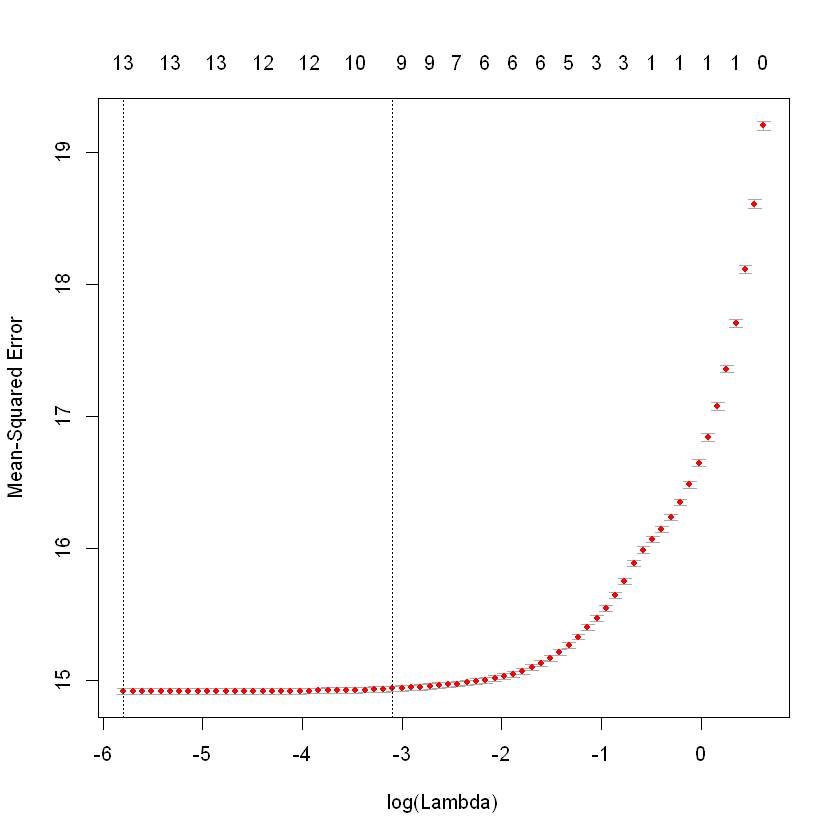

In [24]:
# We can choose lambda by checking the picture, Still kinda subjective
# use cross validation to get optimal value of lambda, 
cvfit <- cv.glmnet(ind, dep)
plot(cvfit)

In [25]:
# Two selected lambdas are shown, 
cvfit$lambda.min # value of lambda gives minimal mean cross validated error

[1] 0.003057465

In [26]:
cvfit$lambda.1se # most regularized model such that error is within one std err of the minimum

[1] 0.04540238

In [27]:
x = coef(cvfit, s = "lambda.min")

In [28]:
coef(cvfit, s = "lambda.1se")

15 x 1 sparse Matrix of class "dgCMatrix"
                                     1
(Intercept)               1.167823e+01
(Intercept)               .           
state_mean_intlow        -1.697205e-01
state_mean_intlowmedium   .           
state_mean_intmediumhigh  .           
home_ownershipOTHER       .           
home_ownershipOWN         8.368299e-04
home_ownershipRENT        4.250984e-01
annual_inc               -1.340958e-06
dti                       6.300477e-02
term 60 months            4.037671e+00
loan_amnt                 4.800711e-06
total_acc                -2.265031e-02
tot_cur_bal              -2.171352e-06
open_acc                 -4.016204e-03

### how to choose the number of features? 
 - if the total number of features are too many --> lse
 - if the total number of features are not too many --> min

# decision tree

In [30]:
library(rpart)

In [32]:
formula <- paste("int_rate ~ state_mean_int + home_ownership + annual_inc + dti + term + loan_amnt + total_acc + tot_cur_bal + open_acc")

In [33]:
tree0 <- rpart(formula, method = 'anova', data = train.sub, control=rpart.control(cp = 0.0001))
# step 1 start with a small cp (complexity parameter, alpha)
# method = 'class' for classification
# method = 'anova' for regression

In [34]:
tree0
# deviance is determined as Sum(observed_i - mu_i)^2, sum of squared error of data in that node
# http://stats.stackexchange.com/questions/6581/what-is-deviance-specifically-in-cart-rpart
# for regression, sum of squared error, for classification, similar to entropy

n= 621165 

node), split, n, deviance, yval
      * denotes terminal node

    1) root 621165 11931520.000 13.243750  
      2) term= 36 months 435016  6457664.000 12.016540  
        4) annual_inc>=49629.5 290217  4150660.000 11.506110  
          8) tot_cur_bal>=115095.5 133750  1855715.000 10.999290  
           16) loan_amnt< 28037.5 119650  1609837.000 10.804280  
             32) annual_inc>=84945.5 57487   724084.800 10.183470  
               64) loan_amnt>=9987.5 44247   513748.300  9.875547  
                128) dti< 23.375 36976   422902.500  9.745665  
                  256) loan_amnt>=21562.5 10826   122161.800  9.360793  
                    512) annual_inc>=104996 7801    83784.870  9.153902 *
                    513) annual_inc< 104996 3025    37181.910  9.894331 *
                  257) loan_amnt< 21562.5 26150   298473.200  9.905001 *
                129) dti>=23.375 7271    87049.900 10.536050 *
               65) loan_amnt< 9987.5 13240   192120.100 11.212540  
   

In [35]:
mean(train$int_rate) # yi is actually mu_i

[1] 13.24375

In [36]:
tree1 <- rpart(formula, method = 'anova', data = train.sub, control=rpart.control(cp = 0.1)) # cp = 1, 0.1, 0.01 (default), 0

In [37]:
tree1

n= 621165 

node), split, n, deviance, yval
      * denotes terminal node

1) root 621165 11931520 13.24375  
  2) term= 36 months 435016  6457664 12.01654 *
  3) term= 60 months 186149  3287672 16.11164 *

increase the value of complexity parameter --> tree became simple

### how to determine the value of complexiy parameter? using printcp

In [38]:
printcp(tree0)
# display the cross validation result
# rel error = sum of squared over all leaf nodes of train data / sum of squared at root node
# xerror = sum of squared over all leaf nodes of left over data / sum of squared at root node


Regression tree:
rpart(formula = formula, data = train.sub, method = "anova", 
    control = rpart.control(cp = 1e-04))

Variables actually used in tree construction:
[1] annual_inc  dti         loan_amnt   open_acc    term        tot_cur_bal
[7] total_acc  

Root node error: 11931524/621165 = 19.208

n= 621165 

           CP nsplit rel error  xerror      xstd
1  0.18322790      0   1.00000 1.00000 0.0017234
2  0.01903849      1   0.81677 0.81678 0.0013897
3  0.00534086      2   0.79773 0.79790 0.0013723
4  0.00428660      3   0.79239 0.79151 0.0013677
5  0.00389035      4   0.78811 0.78631 0.0013583
6  0.00361750      5   0.78422 0.78242 0.0013512
7  0.00357406      6   0.78060 0.77924 0.0013490
8  0.00313623      7   0.77702 0.77667 0.0013470
9  0.00301580      8   0.77389 0.77370 0.0013440
10 0.00245096      9   0.77087 0.77110 0.0013394
11 0.00238353     10   0.76842 0.76899 0.0013354
12 0.00195577     11   0.76604 0.76706 0.0013326
13 0.00152674     12   0.76408 0.76457 0.001328

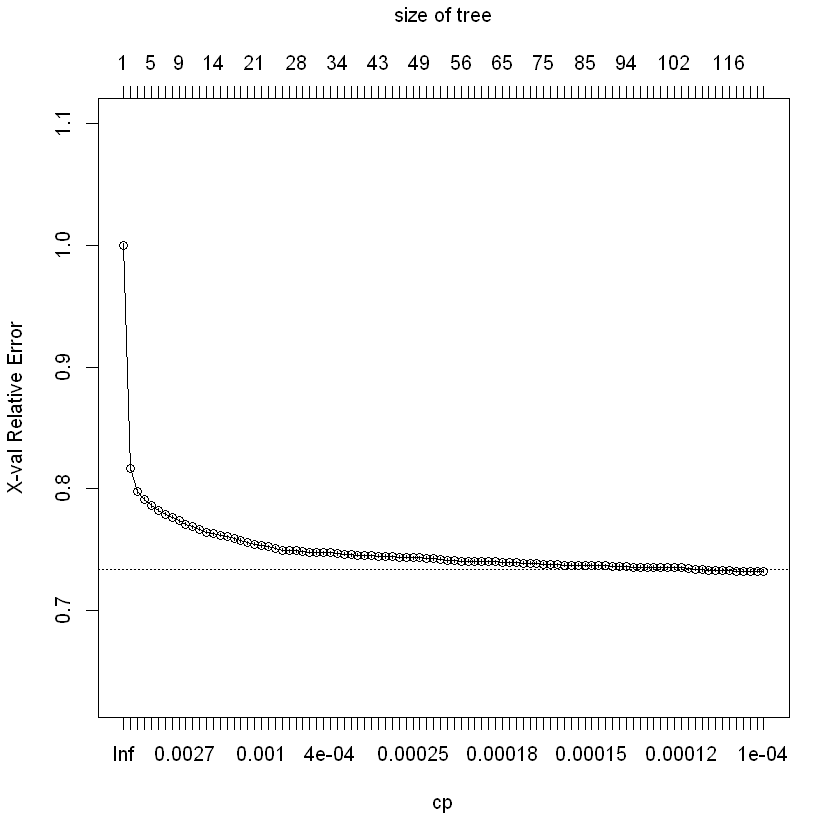

In [39]:
plotcp(tree0) 
# plot xerror

In [41]:
#Pick the tree size that minimizes xerror.
# Hence we want the cp value that minimizes the xerror.
bestcp <- tree0$cptable[which.min(tree0$cptable[,"xerror"]), "CP"]

In [42]:
bestcp

[1] 0.0001001562

In [44]:
cp.tab <- as.data.frame(tree0$cptable)
with(cp.tab, min(which(xerror - 2*xstd < min(xerror))))

[1] 83

In [46]:
bestcp <- cp.tab$CP[with(cp.tab, min(which(xerror - xstd < min(xerror))))]

In [48]:
# Step 3: Prune the tree using the best cp.
tree.pruned <- prune(tree0, cp = bestcp)
tree.pruned

n= 621165 

node), split, n, deviance, yval
      * denotes terminal node

    1) root 621165 11931520.000 13.243750  
      2) term= 36 months 435016  6457664.000 12.016540  
        4) annual_inc>=49629.5 290217  4150660.000 11.506110  
          8) tot_cur_bal>=115095.5 133750  1855715.000 10.999290  
           16) loan_amnt< 28037.5 119650  1609837.000 10.804280  
             32) annual_inc>=84945.5 57487   724084.800 10.183470  
               64) loan_amnt>=9987.5 44247   513748.300  9.875547  
                128) dti< 23.375 36976   422902.500  9.745665  
                  256) loan_amnt>=21562.5 10826   122161.800  9.360793 *
                  257) loan_amnt< 21562.5 26150   298473.200  9.905001 *
                129) dti>=23.375 7271    87049.900 10.536050 *
               65) loan_amnt< 9987.5 13240   192120.100 11.212540  
                130) loan_amnt>=4987.5 10201   140336.700 10.856150 *
                131) loan_amnt< 4987.5 3039    46138.550 12.408840 *
            

In [49]:
test.pred <- predict(tree.pruned, test)
sqrt(sum((test.pred - test$int_rate)^2) / length(test.pred)) # 3.7

[1] 3.75067

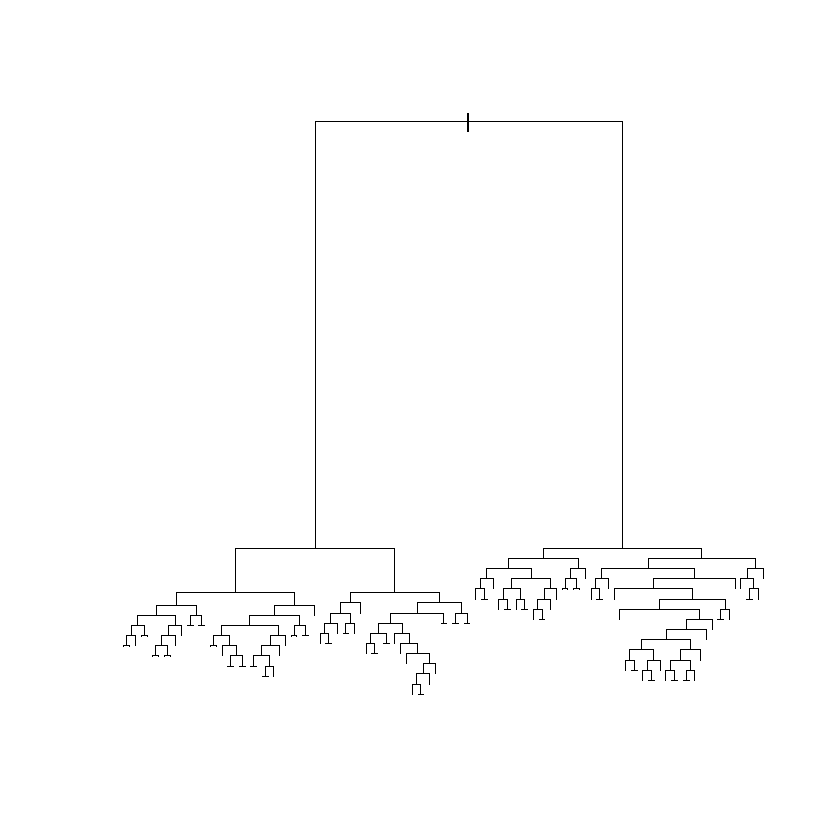

In [50]:
# plot tree
plot(tree.pruned)

no uniform, the length of branch indicates decrease of deviance

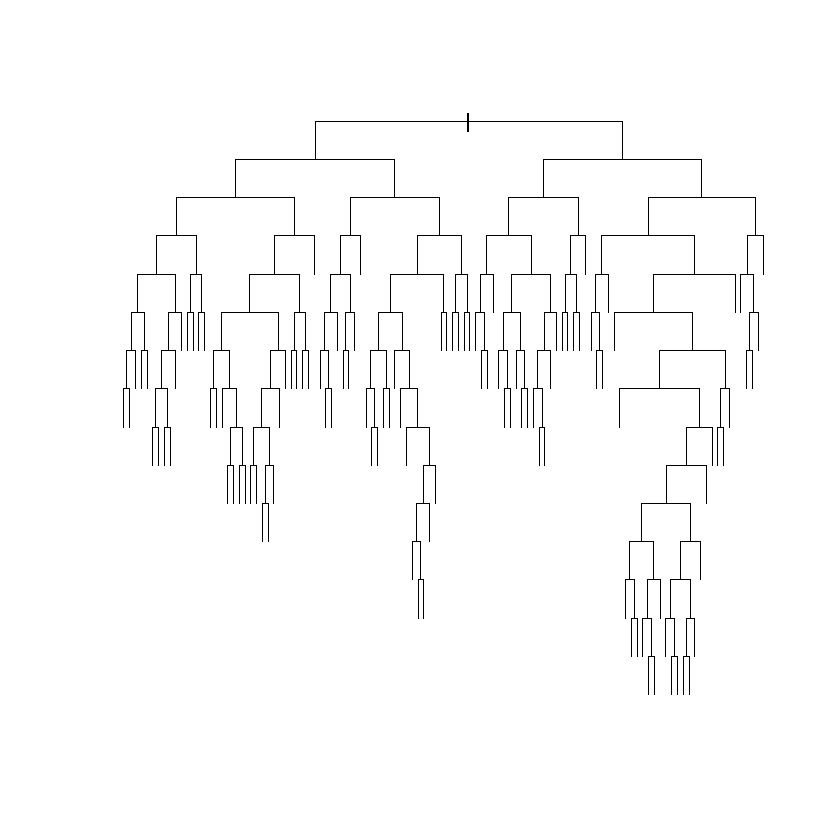

In [56]:
plot(tree.pruned, uniform = TRUE) 

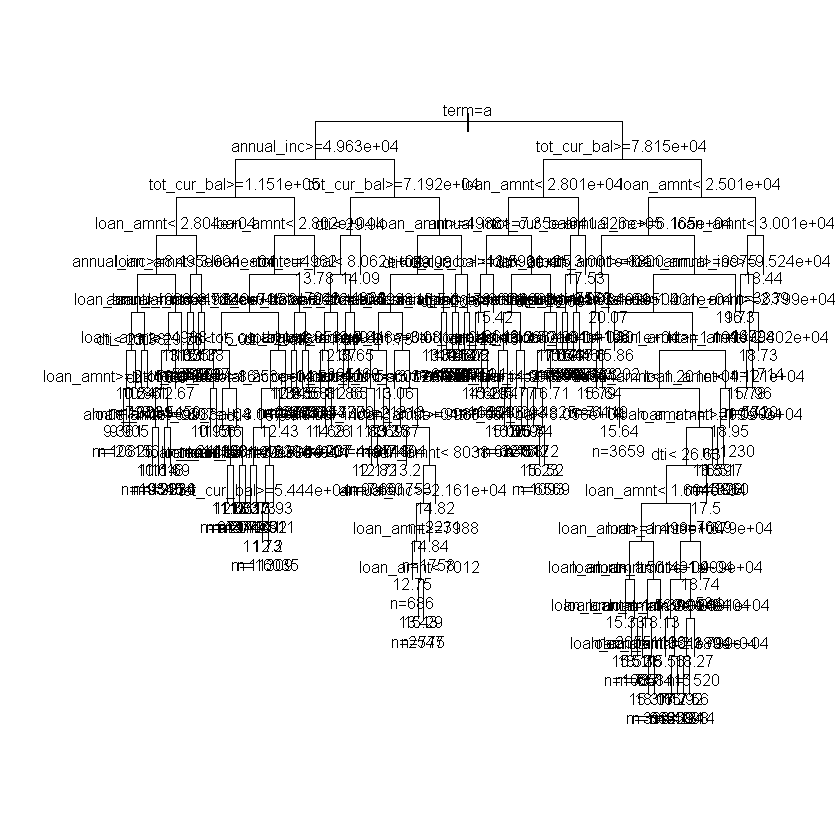

In [57]:
plot(tree.pruned, uniform = TRUE) 
# Since labels often extend outside the plot region it can be helpful to specify xpd = TRUE
text(tree.pruned, cex = 0.8, use.n = TRUE, xpd = TRUE)

 - They can be quite ugly and hard to read, especially when you 
 - have many levels for a factor since the plot automatically labels them using alphabets.

In [80]:
install.packages("rpart.plot",repos="http://cran.rstudio.com/")

Installing package into 'C:/Users/yuanq/Documents/R/win-library/3.4'
(as 'lib' is unspecified)


package 'rpart.plot' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\yuanq\AppData\Local\Temp\RtmpwpyMDC\downloaded_packages


In [82]:
install.packages("rattle",repos="http://cran.rstudio.com/")

Installing package into 'C:/Users/yuanq/Documents/R/win-library/3.4'
(as 'lib' is unspecified)
also installing the dependencies 'RGtk2', 'cairoDevice', 'XML'




  There is a binary version available but the source version is later:
       binary  source needs_compilation
RGtk2 2.20.33 2.20.34              TRUE

  Binaries will be installed
package 'RGtk2' successfully unpacked and MD5 sums checked
package 'cairoDevice' successfully unpacked and MD5 sums checked
package 'XML' successfully unpacked and MD5 sums checked
package 'rattle' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\yuanq\AppData\Local\Temp\RtmpwpyMDC\downloaded_packages


In [84]:
library("rpart.plot")
library(rattle)
# http://blog.revolutionanalytics.com/2013/06/plotting-classification-and-regression-trees-with-plotrpart.html
# plot rpart model


Warning message:
"package 'rattle' was built under R version 3.4.3"Warning message:
"Failed to load RGtk2 dynamic library, attempting to install it."Please install GTK+ from http://ftp.gnome.org/pub/gnome/binaries/win64/gtk+/2.22/gtk+-bundle_2.22.1-20101229_win64.zip
If the package still does not load, please ensure that GTK+ is installed and that it is on your PATH environment variable
IN ANY CASE, RESTART R BEFORE TRYING TO LOAD THE PACKAGE AGAIN
Warning message:
"Failed to load RGtk2 dynamic library, attempting to install it."Please install GTK+ from http://ftp.gnome.org/pub/gnome/binaries/win64/gtk+/2.22/gtk+-bundle_2.22.1-20101229_win64.zip
If the package still does not load, please ensure that GTK+ is installed and that it is on your PATH environment variable
IN ANY CASE, RESTART R BEFORE TRYING TO LOAD THE PACKAGE AGAIN
Warning message:
"Failed to load RGtk2 dynamic library, attempting to install it."Please install GTK+ from http://ftp.gnome.org/pub/gnome/binaries/win64/gtk+/2.2

"Failed to load RGtk2 dynamic library, attempting to install it."Please install GTK+ from http://ftp.gnome.org/pub/gnome/binaries/win64/gtk+/2.22/gtk+-bundle_2.22.1-20101229_win64.zip
If the package still does not load, please ensure that GTK+ is installed and that it is on your PATH environment variable
IN ANY CASE, RESTART R BEFORE TRYING TO LOAD THE PACKAGE AGAIN
Warning message:
"Failed to load RGtk2 dynamic library, attempting to install it."Please install GTK+ from http://ftp.gnome.org/pub/gnome/binaries/win64/gtk+/2.22/gtk+-bundle_2.22.1-20101229_win64.zip
If the package still does not load, please ensure that GTK+ is installed and that it is on your PATH environment variable
IN ANY CASE, RESTART R BEFORE TRYING TO LOAD THE PACKAGE AGAIN
Warning message:
"Failed to load RGtk2 dynamic library, attempting to install it."Please install GTK+ from http://ftp.gnome.org/pub/gnome/binaries/win64/gtk+/2.22/gtk+-bundle_2.22.1-20101229_win64.zip
If the package still does not load, please e

If the package still does not load, please ensure that GTK+ is installed and that it is on your PATH environment variable
IN ANY CASE, RESTART R BEFORE TRYING TO LOAD THE PACKAGE AGAIN
Warning message:
"Failed to load RGtk2 dynamic library, attempting to install it."Please install GTK+ from http://ftp.gnome.org/pub/gnome/binaries/win64/gtk+/2.22/gtk+-bundle_2.22.1-20101229_win64.zip
If the package still does not load, please ensure that GTK+ is installed and that it is on your PATH environment variable
IN ANY CASE, RESTART R BEFORE TRYING TO LOAD THE PACKAGE AGAIN
Warning message:
"Failed to load RGtk2 dynamic library, attempting to install it."Please install GTK+ from http://ftp.gnome.org/pub/gnome/binaries/win64/gtk+/2.22/gtk+-bundle_2.22.1-20101229_win64.zip
If the package still does not load, please ensure that GTK+ is installed and that it is on your PATH environment variable
IN ANY CASE, RESTART R BEFORE TRYING TO LOAD THE PACKAGE AGAIN
Warning message:
"Failed to load RGtk2 dyna

IN ANY CASE, RESTART R BEFORE TRYING TO LOAD THE PACKAGE AGAIN
Warning message:
"Failed to load RGtk2 dynamic library, attempting to install it."Please install GTK+ from http://ftp.gnome.org/pub/gnome/binaries/win64/gtk+/2.22/gtk+-bundle_2.22.1-20101229_win64.zip
If the package still does not load, please ensure that GTK+ is installed and that it is on your PATH environment variable
IN ANY CASE, RESTART R BEFORE TRYING TO LOAD THE PACKAGE AGAIN
Warning message:
"Failed to load RGtk2 dynamic library, attempting to install it."Please install GTK+ from http://ftp.gnome.org/pub/gnome/binaries/win64/gtk+/2.22/gtk+-bundle_2.22.1-20101229_win64.zip
If the package still does not load, please ensure that GTK+ is installed and that it is on your PATH environment variable
IN ANY CASE, RESTART R BEFORE TRYING TO LOAD THE PACKAGE AGAIN
Warning message:
"Failed to load RGtk2 dynamic library, attempting to install it."Please install GTK+ from http://ftp.gnome.org/pub/gnome/binaries/win64/gtk+/2.22/gt

"Failed to load RGtk2 dynamic library, attempting to install it."Please install GTK+ from http://ftp.gnome.org/pub/gnome/binaries/win64/gtk+/2.22/gtk+-bundle_2.22.1-20101229_win64.zip
If the package still does not load, please ensure that GTK+ is installed and that it is on your PATH environment variable
IN ANY CASE, RESTART R BEFORE TRYING TO LOAD THE PACKAGE AGAIN
Warning message:
"Failed to load RGtk2 dynamic library, attempting to install it."Please install GTK+ from http://ftp.gnome.org/pub/gnome/binaries/win64/gtk+/2.22/gtk+-bundle_2.22.1-20101229_win64.zip
If the package still does not load, please ensure that GTK+ is installed and that it is on your PATH environment variable
IN ANY CASE, RESTART R BEFORE TRYING TO LOAD THE PACKAGE AGAIN
Warning message:
"Failed to load RGtk2 dynamic library, attempting to install it."Please install GTK+ from http://ftp.gnome.org/pub/gnome/binaries/win64/gtk+/2.22/gtk+-bundle_2.22.1-20101229_win64.zip
If the package still does not load, please e

If the package still does not load, please ensure that GTK+ is installed and that it is on your PATH environment variable
IN ANY CASE, RESTART R BEFORE TRYING TO LOAD THE PACKAGE AGAIN
Warning message:
"Failed to load RGtk2 dynamic library, attempting to install it."Please install GTK+ from http://ftp.gnome.org/pub/gnome/binaries/win64/gtk+/2.22/gtk+-bundle_2.22.1-20101229_win64.zip
If the package still does not load, please ensure that GTK+ is installed and that it is on your PATH environment variable
IN ANY CASE, RESTART R BEFORE TRYING TO LOAD THE PACKAGE AGAIN
Warning message:
"Failed to load RGtk2 dynamic library, attempting to install it."Please install GTK+ from http://ftp.gnome.org/pub/gnome/binaries/win64/gtk+/2.22/gtk+-bundle_2.22.1-20101229_win64.zip
If the package still does not load, please ensure that GTK+ is installed and that it is on your PATH environment variable
IN ANY CASE, RESTART R BEFORE TRYING TO LOAD THE PACKAGE AGAIN
Warning message:
"Failed to load RGtk2 dyna

IN ANY CASE, RESTART R BEFORE TRYING TO LOAD THE PACKAGE AGAIN
Warning message:
"Failed to load RGtk2 dynamic library, attempting to install it."Please install GTK+ from http://ftp.gnome.org/pub/gnome/binaries/win64/gtk+/2.22/gtk+-bundle_2.22.1-20101229_win64.zip
If the package still does not load, please ensure that GTK+ is installed and that it is on your PATH environment variable
IN ANY CASE, RESTART R BEFORE TRYING TO LOAD THE PACKAGE AGAIN
Warning message:
"Failed to load RGtk2 dynamic library, attempting to install it."Please install GTK+ from http://ftp.gnome.org/pub/gnome/binaries/win64/gtk+/2.22/gtk+-bundle_2.22.1-20101229_win64.zip
If the package still does not load, please ensure that GTK+ is installed and that it is on your PATH environment variable
IN ANY CASE, RESTART R BEFORE TRYING TO LOAD THE PACKAGE AGAIN
Warning message:
"Failed to load RGtk2 dynamic library, attempting to install it."Please install GTK+ from http://ftp.gnome.org/pub/gnome/binaries/win64/gtk+/2.22/gt

"Failed to load RGtk2 dynamic library, attempting to install it."Please install GTK+ from http://ftp.gnome.org/pub/gnome/binaries/win64/gtk+/2.22/gtk+-bundle_2.22.1-20101229_win64.zip
If the package still does not load, please ensure that GTK+ is installed and that it is on your PATH environment variable
IN ANY CASE, RESTART R BEFORE TRYING TO LOAD THE PACKAGE AGAIN
Warning message:
"Failed to load RGtk2 dynamic library, attempting to install it."Please install GTK+ from http://ftp.gnome.org/pub/gnome/binaries/win64/gtk+/2.22/gtk+-bundle_2.22.1-20101229_win64.zip
If the package still does not load, please ensure that GTK+ is installed and that it is on your PATH environment variable
IN ANY CASE, RESTART R BEFORE TRYING TO LOAD THE PACKAGE AGAIN
Warning message:
"Failed to load RGtk2 dynamic library, attempting to install it."Please install GTK+ from http://ftp.gnome.org/pub/gnome/binaries/win64/gtk+/2.22/gtk+-bundle_2.22.1-20101229_win64.zip
If the package still does not load, please e

If the package still does not load, please ensure that GTK+ is installed and that it is on your PATH environment variable
IN ANY CASE, RESTART R BEFORE TRYING TO LOAD THE PACKAGE AGAIN
Warning message:
"Failed to load RGtk2 dynamic library, attempting to install it."Please install GTK+ from http://ftp.gnome.org/pub/gnome/binaries/win64/gtk+/2.22/gtk+-bundle_2.22.1-20101229_win64.zip
If the package still does not load, please ensure that GTK+ is installed and that it is on your PATH environment variable
IN ANY CASE, RESTART R BEFORE TRYING TO LOAD THE PACKAGE AGAIN
Warning message:
"Failed to load RGtk2 dynamic library, attempting to install it."Please install GTK+ from http://ftp.gnome.org/pub/gnome/binaries/win64/gtk+/2.22/gtk+-bundle_2.22.1-20101229_win64.zip
If the package still does not load, please ensure that GTK+ is installed and that it is on your PATH environment variable
IN ANY CASE, RESTART R BEFORE TRYING TO LOAD THE PACKAGE AGAIN
Warning message:
"Failed to load RGtk2 dyna

IN ANY CASE, RESTART R BEFORE TRYING TO LOAD THE PACKAGE AGAIN
Warning message:
"Failed to load RGtk2 dynamic library, attempting to install it."Please install GTK+ from http://ftp.gnome.org/pub/gnome/binaries/win64/gtk+/2.22/gtk+-bundle_2.22.1-20101229_win64.zip
If the package still does not load, please ensure that GTK+ is installed and that it is on your PATH environment variable
IN ANY CASE, RESTART R BEFORE TRYING TO LOAD THE PACKAGE AGAIN
Warning message:
"Failed to load RGtk2 dynamic library, attempting to install it."Please install GTK+ from http://ftp.gnome.org/pub/gnome/binaries/win64/gtk+/2.22/gtk+-bundle_2.22.1-20101229_win64.zip
If the package still does not load, please ensure that GTK+ is installed and that it is on your PATH environment variable
IN ANY CASE, RESTART R BEFORE TRYING TO LOAD THE PACKAGE AGAIN
Warning message:
"Failed to load RGtk2 dynamic library, attempting to install it."Please install GTK+ from http://ftp.gnome.org/pub/gnome/binaries/win64/gtk+/2.22/gt

"Failed to load RGtk2 dynamic library, attempting to install it."Please install GTK+ from http://ftp.gnome.org/pub/gnome/binaries/win64/gtk+/2.22/gtk+-bundle_2.22.1-20101229_win64.zip
If the package still does not load, please ensure that GTK+ is installed and that it is on your PATH environment variable
IN ANY CASE, RESTART R BEFORE TRYING TO LOAD THE PACKAGE AGAIN
Warning message:
"Failed to load RGtk2 dynamic library, attempting to install it."Please install GTK+ from http://ftp.gnome.org/pub/gnome/binaries/win64/gtk+/2.22/gtk+-bundle_2.22.1-20101229_win64.zip
If the package still does not load, please ensure that GTK+ is installed and that it is on your PATH environment variable
IN ANY CASE, RESTART R BEFORE TRYING TO LOAD THE PACKAGE AGAIN
Warning message:
"Failed to load RGtk2 dynamic library, attempting to install it."Please install GTK+ from http://ftp.gnome.org/pub/gnome/binaries/win64/gtk+/2.22/gtk+-bundle_2.22.1-20101229_win64.zip
If the package still does not load, please e

If the package still does not load, please ensure that GTK+ is installed and that it is on your PATH environment variable
IN ANY CASE, RESTART R BEFORE TRYING TO LOAD THE PACKAGE AGAIN
Warning message:
"Failed to load RGtk2 dynamic library, attempting to install it."Please install GTK+ from http://ftp.gnome.org/pub/gnome/binaries/win64/gtk+/2.22/gtk+-bundle_2.22.1-20101229_win64.zip
If the package still does not load, please ensure that GTK+ is installed and that it is on your PATH environment variable
IN ANY CASE, RESTART R BEFORE TRYING TO LOAD THE PACKAGE AGAIN
Warning message:
"Failed to load RGtk2 dynamic library, attempting to install it."Please install GTK+ from http://ftp.gnome.org/pub/gnome/binaries/win64/gtk+/2.22/gtk+-bundle_2.22.1-20101229_win64.zip
If the package still does not load, please ensure that GTK+ is installed and that it is on your PATH environment variable
IN ANY CASE, RESTART R BEFORE TRYING TO LOAD THE PACKAGE AGAIN
Warning message:
"Failed to load RGtk2 dyna

IN ANY CASE, RESTART R BEFORE TRYING TO LOAD THE PACKAGE AGAIN
Warning message:
"Failed to load RGtk2 dynamic library, attempting to install it."Please install GTK+ from http://ftp.gnome.org/pub/gnome/binaries/win64/gtk+/2.22/gtk+-bundle_2.22.1-20101229_win64.zip
If the package still does not load, please ensure that GTK+ is installed and that it is on your PATH environment variable
IN ANY CASE, RESTART R BEFORE TRYING TO LOAD THE PACKAGE AGAIN
Warning message:
"Failed to load RGtk2 dynamic library, attempting to install it."Please install GTK+ from http://ftp.gnome.org/pub/gnome/binaries/win64/gtk+/2.22/gtk+-bundle_2.22.1-20101229_win64.zip
If the package still does not load, please ensure that GTK+ is installed and that it is on your PATH environment variable
IN ANY CASE, RESTART R BEFORE TRYING TO LOAD THE PACKAGE AGAIN
Warning message:
"Failed to load RGtk2 dynamic library, attempting to install it."Please install GTK+ from http://ftp.gnome.org/pub/gnome/binaries/win64/gtk+/2.22/gt

"Failed to load RGtk2 dynamic library, attempting to install it."Please install GTK+ from http://ftp.gnome.org/pub/gnome/binaries/win64/gtk+/2.22/gtk+-bundle_2.22.1-20101229_win64.zip
If the package still does not load, please ensure that GTK+ is installed and that it is on your PATH environment variable
IN ANY CASE, RESTART R BEFORE TRYING TO LOAD THE PACKAGE AGAIN
Warning message:
"Failed to load RGtk2 dynamic library, attempting to install it."Please install GTK+ from http://ftp.gnome.org/pub/gnome/binaries/win64/gtk+/2.22/gtk+-bundle_2.22.1-20101229_win64.zip
If the package still does not load, please ensure that GTK+ is installed and that it is on your PATH environment variable
IN ANY CASE, RESTART R BEFORE TRYING TO LOAD THE PACKAGE AGAIN
Warning message:
"Failed to load RGtk2 dynamic library, attempting to install it."Please install GTK+ from http://ftp.gnome.org/pub/gnome/binaries/win64/gtk+/2.22/gtk+-bundle_2.22.1-20101229_win64.zip
If the package still does not load, please e

If the package still does not load, please ensure that GTK+ is installed and that it is on your PATH environment variable
IN ANY CASE, RESTART R BEFORE TRYING TO LOAD THE PACKAGE AGAIN
Warning message:
"Failed to load RGtk2 dynamic library, attempting to install it."Please install GTK+ from http://ftp.gnome.org/pub/gnome/binaries/win64/gtk+/2.22/gtk+-bundle_2.22.1-20101229_win64.zip
If the package still does not load, please ensure that GTK+ is installed and that it is on your PATH environment variable
IN ANY CASE, RESTART R BEFORE TRYING TO LOAD THE PACKAGE AGAIN
Warning message:
"Failed to load RGtk2 dynamic library, attempting to install it."Please install GTK+ from http://ftp.gnome.org/pub/gnome/binaries/win64/gtk+/2.22/gtk+-bundle_2.22.1-20101229_win64.zip
If the package still does not load, please ensure that GTK+ is installed and that it is on your PATH environment variable
IN ANY CASE, RESTART R BEFORE TRYING TO LOAD THE PACKAGE AGAIN
Warning message:
"Failed to load RGtk2 dyna

IN ANY CASE, RESTART R BEFORE TRYING TO LOAD THE PACKAGE AGAIN
Warning message:
"Failed to load RGtk2 dynamic library, attempting to install it."Please install GTK+ from http://ftp.gnome.org/pub/gnome/binaries/win64/gtk+/2.22/gtk+-bundle_2.22.1-20101229_win64.zip
If the package still does not load, please ensure that GTK+ is installed and that it is on your PATH environment variable
IN ANY CASE, RESTART R BEFORE TRYING TO LOAD THE PACKAGE AGAIN
Warning message:
"Failed to load RGtk2 dynamic library, attempting to install it."Please install GTK+ from http://ftp.gnome.org/pub/gnome/binaries/win64/gtk+/2.22/gtk+-bundle_2.22.1-20101229_win64.zip
If the package still does not load, please ensure that GTK+ is installed and that it is on your PATH environment variable
IN ANY CASE, RESTART R BEFORE TRYING TO LOAD THE PACKAGE AGAIN
Warning message:
"Failed to load RGtk2 dynamic library, attempting to install it."Please install GTK+ from http://ftp.gnome.org/pub/gnome/binaries/win64/gtk+/2.22/gt

"Failed to load RGtk2 dynamic library, attempting to install it."Please install GTK+ from http://ftp.gnome.org/pub/gnome/binaries/win64/gtk+/2.22/gtk+-bundle_2.22.1-20101229_win64.zip
If the package still does not load, please ensure that GTK+ is installed and that it is on your PATH environment variable
IN ANY CASE, RESTART R BEFORE TRYING TO LOAD THE PACKAGE AGAIN
Warning message:
"Failed to load RGtk2 dynamic library, attempting to install it."Please install GTK+ from http://ftp.gnome.org/pub/gnome/binaries/win64/gtk+/2.22/gtk+-bundle_2.22.1-20101229_win64.zip
If the package still does not load, please ensure that GTK+ is installed and that it is on your PATH environment variable
IN ANY CASE, RESTART R BEFORE TRYING TO LOAD THE PACKAGE AGAIN
Warning message:
"Failed to load RGtk2 dynamic library, attempting to install it."Please install GTK+ from http://ftp.gnome.org/pub/gnome/binaries/win64/gtk+/2.22/gtk+-bundle_2.22.1-20101229_win64.zip
If the package still does not load, please e

If the package still does not load, please ensure that GTK+ is installed and that it is on your PATH environment variable
IN ANY CASE, RESTART R BEFORE TRYING TO LOAD THE PACKAGE AGAIN
Warning message:
"Failed to load RGtk2 dynamic library, attempting to install it."Please install GTK+ from http://ftp.gnome.org/pub/gnome/binaries/win64/gtk+/2.22/gtk+-bundle_2.22.1-20101229_win64.zip
If the package still does not load, please ensure that GTK+ is installed and that it is on your PATH environment variable
IN ANY CASE, RESTART R BEFORE TRYING TO LOAD THE PACKAGE AGAIN
Warning message:
"Failed to load RGtk2 dynamic library, attempting to install it."Please install GTK+ from http://ftp.gnome.org/pub/gnome/binaries/win64/gtk+/2.22/gtk+-bundle_2.22.1-20101229_win64.zip
If the package still does not load, please ensure that GTK+ is installed and that it is on your PATH environment variable
IN ANY CASE, RESTART R BEFORE TRYING TO LOAD THE PACKAGE AGAIN
Warning message:
"Failed to load RGtk2 dyna

IN ANY CASE, RESTART R BEFORE TRYING TO LOAD THE PACKAGE AGAIN
Warning message:
"Failed to load RGtk2 dynamic library, attempting to install it."Please install GTK+ from http://ftp.gnome.org/pub/gnome/binaries/win64/gtk+/2.22/gtk+-bundle_2.22.1-20101229_win64.zip
If the package still does not load, please ensure that GTK+ is installed and that it is on your PATH environment variable
IN ANY CASE, RESTART R BEFORE TRYING TO LOAD THE PACKAGE AGAIN
Warning message:
"Failed to load RGtk2 dynamic library, attempting to install it."Please install GTK+ from http://ftp.gnome.org/pub/gnome/binaries/win64/gtk+/2.22/gtk+-bundle_2.22.1-20101229_win64.zip
If the package still does not load, please ensure that GTK+ is installed and that it is on your PATH environment variable
IN ANY CASE, RESTART R BEFORE TRYING TO LOAD THE PACKAGE AGAIN
Warning message:
"Failed to load RGtk2 dynamic library, attempting to install it."Please install GTK+ from http://ftp.gnome.org/pub/gnome/binaries/win64/gtk+/2.22/gt

"Failed to load RGtk2 dynamic library, attempting to install it."Please install GTK+ from http://ftp.gnome.org/pub/gnome/binaries/win64/gtk+/2.22/gtk+-bundle_2.22.1-20101229_win64.zip
If the package still does not load, please ensure that GTK+ is installed and that it is on your PATH environment variable
IN ANY CASE, RESTART R BEFORE TRYING TO LOAD THE PACKAGE AGAIN
Warning message:
"Failed to load RGtk2 dynamic library, attempting to install it."Please install GTK+ from http://ftp.gnome.org/pub/gnome/binaries/win64/gtk+/2.22/gtk+-bundle_2.22.1-20101229_win64.zip
If the package still does not load, please ensure that GTK+ is installed and that it is on your PATH environment variable
IN ANY CASE, RESTART R BEFORE TRYING TO LOAD THE PACKAGE AGAIN
Warning message:
"Failed to load RGtk2 dynamic library, attempting to install it."Please install GTK+ from http://ftp.gnome.org/pub/gnome/binaries/win64/gtk+/2.22/gtk+-bundle_2.22.1-20101229_win64.zip
If the package still does not load, please e

If the package still does not load, please ensure that GTK+ is installed and that it is on your PATH environment variable
IN ANY CASE, RESTART R BEFORE TRYING TO LOAD THE PACKAGE AGAIN
Warning message:
"Failed to load RGtk2 dynamic library, attempting to install it."Please install GTK+ from http://ftp.gnome.org/pub/gnome/binaries/win64/gtk+/2.22/gtk+-bundle_2.22.1-20101229_win64.zip
If the package still does not load, please ensure that GTK+ is installed and that it is on your PATH environment variable
IN ANY CASE, RESTART R BEFORE TRYING TO LOAD THE PACKAGE AGAIN
Warning message:
"Failed to load RGtk2 dynamic library, attempting to install it."Please install GTK+ from http://ftp.gnome.org/pub/gnome/binaries/win64/gtk+/2.22/gtk+-bundle_2.22.1-20101229_win64.zip
If the package still does not load, please ensure that GTK+ is installed and that it is on your PATH environment variable
IN ANY CASE, RESTART R BEFORE TRYING TO LOAD THE PACKAGE AGAIN
Warning message:
"Failed to load RGtk2 dyna

IN ANY CASE, RESTART R BEFORE TRYING TO LOAD THE PACKAGE AGAIN
Warning message:
"Failed to load RGtk2 dynamic library, attempting to install it."Please install GTK+ from http://ftp.gnome.org/pub/gnome/binaries/win64/gtk+/2.22/gtk+-bundle_2.22.1-20101229_win64.zip
If the package still does not load, please ensure that GTK+ is installed and that it is on your PATH environment variable
IN ANY CASE, RESTART R BEFORE TRYING TO LOAD THE PACKAGE AGAIN
Warning message:
"Failed to load RGtk2 dynamic library, attempting to install it."Please install GTK+ from http://ftp.gnome.org/pub/gnome/binaries/win64/gtk+/2.22/gtk+-bundle_2.22.1-20101229_win64.zip
If the package still does not load, please ensure that GTK+ is installed and that it is on your PATH environment variable
IN ANY CASE, RESTART R BEFORE TRYING TO LOAD THE PACKAGE AGAIN
Warning message:
"Failed to load RGtk2 dynamic library, attempting to install it."Please install GTK+ from http://ftp.gnome.org/pub/gnome/binaries/win64/gtk+/2.22/gt

"Failed to load RGtk2 dynamic library, attempting to install it."Please install GTK+ from http://ftp.gnome.org/pub/gnome/binaries/win64/gtk+/2.22/gtk+-bundle_2.22.1-20101229_win64.zip
If the package still does not load, please ensure that GTK+ is installed and that it is on your PATH environment variable
IN ANY CASE, RESTART R BEFORE TRYING TO LOAD THE PACKAGE AGAIN
Warning message:
"Failed to load RGtk2 dynamic library, attempting to install it."Please install GTK+ from http://ftp.gnome.org/pub/gnome/binaries/win64/gtk+/2.22/gtk+-bundle_2.22.1-20101229_win64.zip
If the package still does not load, please ensure that GTK+ is installed and that it is on your PATH environment variable
IN ANY CASE, RESTART R BEFORE TRYING TO LOAD THE PACKAGE AGAIN
Warning message:
"Failed to load RGtk2 dynamic library, attempting to install it."Please install GTK+ from http://ftp.gnome.org/pub/gnome/binaries/win64/gtk+/2.22/gtk+-bundle_2.22.1-20101229_win64.zip
If the package still does not load, please e

If the package still does not load, please ensure that GTK+ is installed and that it is on your PATH environment variable
IN ANY CASE, RESTART R BEFORE TRYING TO LOAD THE PACKAGE AGAIN
Warning message:
"Failed to load RGtk2 dynamic library, attempting to install it."Please install GTK+ from http://ftp.gnome.org/pub/gnome/binaries/win64/gtk+/2.22/gtk+-bundle_2.22.1-20101229_win64.zip
If the package still does not load, please ensure that GTK+ is installed and that it is on your PATH environment variable
IN ANY CASE, RESTART R BEFORE TRYING TO LOAD THE PACKAGE AGAIN
Warning message:
"Failed to load RGtk2 dynamic library, attempting to install it."Please install GTK+ from http://ftp.gnome.org/pub/gnome/binaries/win64/gtk+/2.22/gtk+-bundle_2.22.1-20101229_win64.zip
If the package still does not load, please ensure that GTK+ is installed and that it is on your PATH environment variable
IN ANY CASE, RESTART R BEFORE TRYING TO LOAD THE PACKAGE AGAIN
Warning message:
"Failed to load RGtk2 dyna

IN ANY CASE, RESTART R BEFORE TRYING TO LOAD THE PACKAGE AGAIN
Warning message:
"Failed to load RGtk2 dynamic library, attempting to install it."Please install GTK+ from http://ftp.gnome.org/pub/gnome/binaries/win64/gtk+/2.22/gtk+-bundle_2.22.1-20101229_win64.zip
If the package still does not load, please ensure that GTK+ is installed and that it is on your PATH environment variable
IN ANY CASE, RESTART R BEFORE TRYING TO LOAD THE PACKAGE AGAIN
Warning message:
"Failed to load RGtk2 dynamic library, attempting to install it."Please install GTK+ from http://ftp.gnome.org/pub/gnome/binaries/win64/gtk+/2.22/gtk+-bundle_2.22.1-20101229_win64.zip
If the package still does not load, please ensure that GTK+ is installed and that it is on your PATH environment variable
IN ANY CASE, RESTART R BEFORE TRYING TO LOAD THE PACKAGE AGAIN
Warning message:
"Failed to load RGtk2 dynamic library, attempting to install it."Please install GTK+ from http://ftp.gnome.org/pub/gnome/binaries/win64/gtk+/2.22/gt

"Failed to load RGtk2 dynamic library, attempting to install it."Please install GTK+ from http://ftp.gnome.org/pub/gnome/binaries/win64/gtk+/2.22/gtk+-bundle_2.22.1-20101229_win64.zip
If the package still does not load, please ensure that GTK+ is installed and that it is on your PATH environment variable
IN ANY CASE, RESTART R BEFORE TRYING TO LOAD THE PACKAGE AGAIN
Warning message:
"Failed to load RGtk2 dynamic library, attempting to install it."Please install GTK+ from http://ftp.gnome.org/pub/gnome/binaries/win64/gtk+/2.22/gtk+-bundle_2.22.1-20101229_win64.zip
If the package still does not load, please ensure that GTK+ is installed and that it is on your PATH environment variable
IN ANY CASE, RESTART R BEFORE TRYING TO LOAD THE PACKAGE AGAIN
Warning message:
"Failed to load RGtk2 dynamic library, attempting to install it."Please install GTK+ from http://ftp.gnome.org/pub/gnome/binaries/win64/gtk+/2.22/gtk+-bundle_2.22.1-20101229_win64.zip
If the package still does not load, please e

If the package still does not load, please ensure that GTK+ is installed and that it is on your PATH environment variable
IN ANY CASE, RESTART R BEFORE TRYING TO LOAD THE PACKAGE AGAIN
Warning message:
"Failed to load RGtk2 dynamic library, attempting to install it."Please install GTK+ from http://ftp.gnome.org/pub/gnome/binaries/win64/gtk+/2.22/gtk+-bundle_2.22.1-20101229_win64.zip
If the package still does not load, please ensure that GTK+ is installed and that it is on your PATH environment variable
IN ANY CASE, RESTART R BEFORE TRYING TO LOAD THE PACKAGE AGAIN
Warning message:
"Failed to load RGtk2 dynamic library, attempting to install it."Please install GTK+ from http://ftp.gnome.org/pub/gnome/binaries/win64/gtk+/2.22/gtk+-bundle_2.22.1-20101229_win64.zip
If the package still does not load, please ensure that GTK+ is installed and that it is on your PATH environment variable
IN ANY CASE, RESTART R BEFORE TRYING TO LOAD THE PACKAGE AGAIN
Warning message:
"Failed to load RGtk2 dyna

IN ANY CASE, RESTART R BEFORE TRYING TO LOAD THE PACKAGE AGAIN
Warning message:
"Failed to load RGtk2 dynamic library, attempting to install it."Please install GTK+ from http://ftp.gnome.org/pub/gnome/binaries/win64/gtk+/2.22/gtk+-bundle_2.22.1-20101229_win64.zip
If the package still does not load, please ensure that GTK+ is installed and that it is on your PATH environment variable
IN ANY CASE, RESTART R BEFORE TRYING TO LOAD THE PACKAGE AGAIN
Warning message:
"Failed to load RGtk2 dynamic library, attempting to install it."Please install GTK+ from http://ftp.gnome.org/pub/gnome/binaries/win64/gtk+/2.22/gtk+-bundle_2.22.1-20101229_win64.zip
If the package still does not load, please ensure that GTK+ is installed and that it is on your PATH environment variable
IN ANY CASE, RESTART R BEFORE TRYING TO LOAD THE PACKAGE AGAIN
Warning message:
"Failed to load RGtk2 dynamic library, attempting to install it."Please install GTK+ from http://ftp.gnome.org/pub/gnome/binaries/win64/gtk+/2.22/gt

"Failed to load RGtk2 dynamic library, attempting to install it."Please install GTK+ from http://ftp.gnome.org/pub/gnome/binaries/win64/gtk+/2.22/gtk+-bundle_2.22.1-20101229_win64.zip
If the package still does not load, please ensure that GTK+ is installed and that it is on your PATH environment variable
IN ANY CASE, RESTART R BEFORE TRYING TO LOAD THE PACKAGE AGAIN
Warning message:
"Failed to load RGtk2 dynamic library, attempting to install it."Please install GTK+ from http://ftp.gnome.org/pub/gnome/binaries/win64/gtk+/2.22/gtk+-bundle_2.22.1-20101229_win64.zip
If the package still does not load, please ensure that GTK+ is installed and that it is on your PATH environment variable
IN ANY CASE, RESTART R BEFORE TRYING TO LOAD THE PACKAGE AGAIN
Warning message:
"Failed to load RGtk2 dynamic library, attempting to install it."Please install GTK+ from http://ftp.gnome.org/pub/gnome/binaries/win64/gtk+/2.22/gtk+-bundle_2.22.1-20101229_win64.zip
If the package still does not load, please e

If the package still does not load, please ensure that GTK+ is installed and that it is on your PATH environment variable
IN ANY CASE, RESTART R BEFORE TRYING TO LOAD THE PACKAGE AGAIN
Warning message:
"Failed to load RGtk2 dynamic library, attempting to install it."Please install GTK+ from http://ftp.gnome.org/pub/gnome/binaries/win64/gtk+/2.22/gtk+-bundle_2.22.1-20101229_win64.zip
If the package still does not load, please ensure that GTK+ is installed and that it is on your PATH environment variable
IN ANY CASE, RESTART R BEFORE TRYING TO LOAD THE PACKAGE AGAIN
Warning message:
"Failed to load RGtk2 dynamic library, attempting to install it."Please install GTK+ from http://ftp.gnome.org/pub/gnome/binaries/win64/gtk+/2.22/gtk+-bundle_2.22.1-20101229_win64.zip
If the package still does not load, please ensure that GTK+ is installed and that it is on your PATH environment variable
IN ANY CASE, RESTART R BEFORE TRYING TO LOAD THE PACKAGE AGAIN
Warning message:
"Failed to load RGtk2 dyna

IN ANY CASE, RESTART R BEFORE TRYING TO LOAD THE PACKAGE AGAIN
Warning message:
"Failed to load RGtk2 dynamic library, attempting to install it."Please install GTK+ from http://ftp.gnome.org/pub/gnome/binaries/win64/gtk+/2.22/gtk+-bundle_2.22.1-20101229_win64.zip
If the package still does not load, please ensure that GTK+ is installed and that it is on your PATH environment variable
IN ANY CASE, RESTART R BEFORE TRYING TO LOAD THE PACKAGE AGAIN
Warning message:
"Failed to load RGtk2 dynamic library, attempting to install it."Please install GTK+ from http://ftp.gnome.org/pub/gnome/binaries/win64/gtk+/2.22/gtk+-bundle_2.22.1-20101229_win64.zip
If the package still does not load, please ensure that GTK+ is installed and that it is on your PATH environment variable
IN ANY CASE, RESTART R BEFORE TRYING TO LOAD THE PACKAGE AGAIN
Warning message:
"Failed to load RGtk2 dynamic library, attempting to install it."Please install GTK+ from http://ftp.gnome.org/pub/gnome/binaries/win64/gtk+/2.22/gt

"Failed to load RGtk2 dynamic library, attempting to install it."Please install GTK+ from http://ftp.gnome.org/pub/gnome/binaries/win64/gtk+/2.22/gtk+-bundle_2.22.1-20101229_win64.zip
If the package still does not load, please ensure that GTK+ is installed and that it is on your PATH environment variable
IN ANY CASE, RESTART R BEFORE TRYING TO LOAD THE PACKAGE AGAIN
Warning message:
"Failed to load RGtk2 dynamic library, attempting to install it."Please install GTK+ from http://ftp.gnome.org/pub/gnome/binaries/win64/gtk+/2.22/gtk+-bundle_2.22.1-20101229_win64.zip
If the package still does not load, please ensure that GTK+ is installed and that it is on your PATH environment variable
IN ANY CASE, RESTART R BEFORE TRYING TO LOAD THE PACKAGE AGAIN
Warning message:
"Failed to load RGtk2 dynamic library, attempting to install it."Please install GTK+ from http://ftp.gnome.org/pub/gnome/binaries/win64/gtk+/2.22/gtk+-bundle_2.22.1-20101229_win64.zip
If the package still does not load, please e

If the package still does not load, please ensure that GTK+ is installed and that it is on your PATH environment variable
IN ANY CASE, RESTART R BEFORE TRYING TO LOAD THE PACKAGE AGAIN
Warning message:
"Failed to load RGtk2 dynamic library, attempting to install it."Please install GTK+ from http://ftp.gnome.org/pub/gnome/binaries/win64/gtk+/2.22/gtk+-bundle_2.22.1-20101229_win64.zip
If the package still does not load, please ensure that GTK+ is installed and that it is on your PATH environment variable
IN ANY CASE, RESTART R BEFORE TRYING TO LOAD THE PACKAGE AGAIN
Warning message:
"Failed to load RGtk2 dynamic library, attempting to install it."Please install GTK+ from http://ftp.gnome.org/pub/gnome/binaries/win64/gtk+/2.22/gtk+-bundle_2.22.1-20101229_win64.zip
If the package still does not load, please ensure that GTK+ is installed and that it is on your PATH environment variable
IN ANY CASE, RESTART R BEFORE TRYING TO LOAD THE PACKAGE AGAIN
Warning message:
"Failed to load RGtk2 dyna

IN ANY CASE, RESTART R BEFORE TRYING TO LOAD THE PACKAGE AGAIN
Warning message:
"Failed to load RGtk2 dynamic library, attempting to install it."Please install GTK+ from http://ftp.gnome.org/pub/gnome/binaries/win64/gtk+/2.22/gtk+-bundle_2.22.1-20101229_win64.zip
If the package still does not load, please ensure that GTK+ is installed and that it is on your PATH environment variable
IN ANY CASE, RESTART R BEFORE TRYING TO LOAD THE PACKAGE AGAIN
Warning message:
"Failed to load RGtk2 dynamic library, attempting to install it."Please install GTK+ from http://ftp.gnome.org/pub/gnome/binaries/win64/gtk+/2.22/gtk+-bundle_2.22.1-20101229_win64.zip
If the package still does not load, please ensure that GTK+ is installed and that it is on your PATH environment variable
IN ANY CASE, RESTART R BEFORE TRYING TO LOAD THE PACKAGE AGAIN
Warning message:
"Failed to load RGtk2 dynamic library, attempting to install it."Please install GTK+ from http://ftp.gnome.org/pub/gnome/binaries/win64/gtk+/2.22/gt

"Failed to load RGtk2 dynamic library, attempting to install it."Please install GTK+ from http://ftp.gnome.org/pub/gnome/binaries/win64/gtk+/2.22/gtk+-bundle_2.22.1-20101229_win64.zip
If the package still does not load, please ensure that GTK+ is installed and that it is on your PATH environment variable
IN ANY CASE, RESTART R BEFORE TRYING TO LOAD THE PACKAGE AGAIN
Warning message:
"Failed to load RGtk2 dynamic library, attempting to install it."Please install GTK+ from http://ftp.gnome.org/pub/gnome/binaries/win64/gtk+/2.22/gtk+-bundle_2.22.1-20101229_win64.zip
If the package still does not load, please ensure that GTK+ is installed and that it is on your PATH environment variable
IN ANY CASE, RESTART R BEFORE TRYING TO LOAD THE PACKAGE AGAIN
Warning message:
"Failed to load RGtk2 dynamic library, attempting to install it."Please install GTK+ from http://ftp.gnome.org/pub/gnome/binaries/win64/gtk+/2.22/gtk+-bundle_2.22.1-20101229_win64.zip
If the package still does not load, please e

If the package still does not load, please ensure that GTK+ is installed and that it is on your PATH environment variable
IN ANY CASE, RESTART R BEFORE TRYING TO LOAD THE PACKAGE AGAIN
Warning message:
"Failed to load RGtk2 dynamic library, attempting to install it."Please install GTK+ from http://ftp.gnome.org/pub/gnome/binaries/win64/gtk+/2.22/gtk+-bundle_2.22.1-20101229_win64.zip
If the package still does not load, please ensure that GTK+ is installed and that it is on your PATH environment variable
IN ANY CASE, RESTART R BEFORE TRYING TO LOAD THE PACKAGE AGAIN
Warning message:
"Failed to load RGtk2 dynamic library, attempting to install it."Please install GTK+ from http://ftp.gnome.org/pub/gnome/binaries/win64/gtk+/2.22/gtk+-bundle_2.22.1-20101229_win64.zip
If the package still does not load, please ensure that GTK+ is installed and that it is on your PATH environment variable
IN ANY CASE, RESTART R BEFORE TRYING TO LOAD THE PACKAGE AGAIN
Warning message:
"Failed to load RGtk2 dyna

IN ANY CASE, RESTART R BEFORE TRYING TO LOAD THE PACKAGE AGAIN
Warning message:
"Failed to load RGtk2 dynamic library, attempting to install it."Please install GTK+ from http://ftp.gnome.org/pub/gnome/binaries/win64/gtk+/2.22/gtk+-bundle_2.22.1-20101229_win64.zip
If the package still does not load, please ensure that GTK+ is installed and that it is on your PATH environment variable
IN ANY CASE, RESTART R BEFORE TRYING TO LOAD THE PACKAGE AGAIN
Warning message:
"Failed to load RGtk2 dynamic library, attempting to install it."Please install GTK+ from http://ftp.gnome.org/pub/gnome/binaries/win64/gtk+/2.22/gtk+-bundle_2.22.1-20101229_win64.zip
If the package still does not load, please ensure that GTK+ is installed and that it is on your PATH environment variable
IN ANY CASE, RESTART R BEFORE TRYING TO LOAD THE PACKAGE AGAIN
Warning message:
"Failed to load RGtk2 dynamic library, attempting to install it."Please install GTK+ from http://ftp.gnome.org/pub/gnome/binaries/win64/gtk+/2.22/gt

"Failed to load RGtk2 dynamic library, attempting to install it."Please install GTK+ from http://ftp.gnome.org/pub/gnome/binaries/win64/gtk+/2.22/gtk+-bundle_2.22.1-20101229_win64.zip
If the package still does not load, please ensure that GTK+ is installed and that it is on your PATH environment variable
IN ANY CASE, RESTART R BEFORE TRYING TO LOAD THE PACKAGE AGAIN
Warning message:
"Failed to load RGtk2 dynamic library, attempting to install it."Please install GTK+ from http://ftp.gnome.org/pub/gnome/binaries/win64/gtk+/2.22/gtk+-bundle_2.22.1-20101229_win64.zip
If the package still does not load, please ensure that GTK+ is installed and that it is on your PATH environment variable
IN ANY CASE, RESTART R BEFORE TRYING TO LOAD THE PACKAGE AGAIN
Warning message:
"Failed to load RGtk2 dynamic library, attempting to install it."Please install GTK+ from http://ftp.gnome.org/pub/gnome/binaries/win64/gtk+/2.22/gtk+-bundle_2.22.1-20101229_win64.zip
If the package still does not load, please e

If the package still does not load, please ensure that GTK+ is installed and that it is on your PATH environment variable
IN ANY CASE, RESTART R BEFORE TRYING TO LOAD THE PACKAGE AGAIN
Warning message:
"Failed to load RGtk2 dynamic library, attempting to install it."Please install GTK+ from http://ftp.gnome.org/pub/gnome/binaries/win64/gtk+/2.22/gtk+-bundle_2.22.1-20101229_win64.zip
If the package still does not load, please ensure that GTK+ is installed and that it is on your PATH environment variable
IN ANY CASE, RESTART R BEFORE TRYING TO LOAD THE PACKAGE AGAIN
Warning message:
"Failed to load RGtk2 dynamic library, attempting to install it."Please install GTK+ from http://ftp.gnome.org/pub/gnome/binaries/win64/gtk+/2.22/gtk+-bundle_2.22.1-20101229_win64.zip
If the package still does not load, please ensure that GTK+ is installed and that it is on your PATH environment variable
IN ANY CASE, RESTART R BEFORE TRYING TO LOAD THE PACKAGE AGAIN
Warning message:
"Failed to load RGtk2 dyna

IN ANY CASE, RESTART R BEFORE TRYING TO LOAD THE PACKAGE AGAIN
Warning message:
"Failed to load RGtk2 dynamic library, attempting to install it."Please install GTK+ from http://ftp.gnome.org/pub/gnome/binaries/win64/gtk+/2.22/gtk+-bundle_2.22.1-20101229_win64.zip
If the package still does not load, please ensure that GTK+ is installed and that it is on your PATH environment variable
IN ANY CASE, RESTART R BEFORE TRYING TO LOAD THE PACKAGE AGAIN
Warning message:
"Failed to load RGtk2 dynamic library, attempting to install it."Please install GTK+ from http://ftp.gnome.org/pub/gnome/binaries/win64/gtk+/2.22/gtk+-bundle_2.22.1-20101229_win64.zip
If the package still does not load, please ensure that GTK+ is installed and that it is on your PATH environment variable
IN ANY CASE, RESTART R BEFORE TRYING TO LOAD THE PACKAGE AGAIN
Warning message:
"Failed to load RGtk2 dynamic library, attempting to install it."Please install GTK+ from http://ftp.gnome.org/pub/gnome/binaries/win64/gtk+/2.22/gt

"Failed to load RGtk2 dynamic library, attempting to install it."Please install GTK+ from http://ftp.gnome.org/pub/gnome/binaries/win64/gtk+/2.22/gtk+-bundle_2.22.1-20101229_win64.zip
If the package still does not load, please ensure that GTK+ is installed and that it is on your PATH environment variable
IN ANY CASE, RESTART R BEFORE TRYING TO LOAD THE PACKAGE AGAIN
Warning message:
"Failed to load RGtk2 dynamic library, attempting to install it."Please install GTK+ from http://ftp.gnome.org/pub/gnome/binaries/win64/gtk+/2.22/gtk+-bundle_2.22.1-20101229_win64.zip
If the package still does not load, please ensure that GTK+ is installed and that it is on your PATH environment variable
IN ANY CASE, RESTART R BEFORE TRYING TO LOAD THE PACKAGE AGAIN
Warning message:
"Failed to load RGtk2 dynamic library, attempting to install it."Please install GTK+ from http://ftp.gnome.org/pub/gnome/binaries/win64/gtk+/2.22/gtk+-bundle_2.22.1-20101229_win64.zip
If the package still does not load, please e

If the package still does not load, please ensure that GTK+ is installed and that it is on your PATH environment variable
IN ANY CASE, RESTART R BEFORE TRYING TO LOAD THE PACKAGE AGAIN
Warning message:
"Failed to load RGtk2 dynamic library, attempting to install it."Please install GTK+ from http://ftp.gnome.org/pub/gnome/binaries/win64/gtk+/2.22/gtk+-bundle_2.22.1-20101229_win64.zip
If the package still does not load, please ensure that GTK+ is installed and that it is on your PATH environment variable
IN ANY CASE, RESTART R BEFORE TRYING TO LOAD THE PACKAGE AGAIN
Warning message:
"Failed to load RGtk2 dynamic library, attempting to install it."Please install GTK+ from http://ftp.gnome.org/pub/gnome/binaries/win64/gtk+/2.22/gtk+-bundle_2.22.1-20101229_win64.zip
If the package still does not load, please ensure that GTK+ is installed and that it is on your PATH environment variable
IN ANY CASE, RESTART R BEFORE TRYING TO LOAD THE PACKAGE AGAIN
Warning message:
"Failed to load RGtk2 dyna

IN ANY CASE, RESTART R BEFORE TRYING TO LOAD THE PACKAGE AGAIN
Warning message:
"Failed to load RGtk2 dynamic library, attempting to install it."Please install GTK+ from http://ftp.gnome.org/pub/gnome/binaries/win64/gtk+/2.22/gtk+-bundle_2.22.1-20101229_win64.zip
If the package still does not load, please ensure that GTK+ is installed and that it is on your PATH environment variable
IN ANY CASE, RESTART R BEFORE TRYING TO LOAD THE PACKAGE AGAIN
Warning message:
"Failed to load RGtk2 dynamic library, attempting to install it."Please install GTK+ from http://ftp.gnome.org/pub/gnome/binaries/win64/gtk+/2.22/gtk+-bundle_2.22.1-20101229_win64.zip
If the package still does not load, please ensure that GTK+ is installed and that it is on your PATH environment variable
IN ANY CASE, RESTART R BEFORE TRYING TO LOAD THE PACKAGE AGAIN
Warning message:
"Failed to load RGtk2 dynamic library, attempting to install it."Please install GTK+ from http://ftp.gnome.org/pub/gnome/binaries/win64/gtk+/2.22/gt

"Failed to load RGtk2 dynamic library, attempting to install it."Please install GTK+ from http://ftp.gnome.org/pub/gnome/binaries/win64/gtk+/2.22/gtk+-bundle_2.22.1-20101229_win64.zip
If the package still does not load, please ensure that GTK+ is installed and that it is on your PATH environment variable
IN ANY CASE, RESTART R BEFORE TRYING TO LOAD THE PACKAGE AGAIN
Warning message:
"Failed to load RGtk2 dynamic library, attempting to install it."Please install GTK+ from http://ftp.gnome.org/pub/gnome/binaries/win64/gtk+/2.22/gtk+-bundle_2.22.1-20101229_win64.zip
If the package still does not load, please ensure that GTK+ is installed and that it is on your PATH environment variable
IN ANY CASE, RESTART R BEFORE TRYING TO LOAD THE PACKAGE AGAIN
Warning message:
"Failed to load RGtk2 dynamic library, attempting to install it."Please install GTK+ from http://ftp.gnome.org/pub/gnome/binaries/win64/gtk+/2.22/gtk+-bundle_2.22.1-20101229_win64.zip
If the package still does not load, please e

If the package still does not load, please ensure that GTK+ is installed and that it is on your PATH environment variable
IN ANY CASE, RESTART R BEFORE TRYING TO LOAD THE PACKAGE AGAIN
Warning message:
"Failed to load RGtk2 dynamic library, attempting to install it."Please install GTK+ from http://ftp.gnome.org/pub/gnome/binaries/win64/gtk+/2.22/gtk+-bundle_2.22.1-20101229_win64.zip
If the package still does not load, please ensure that GTK+ is installed and that it is on your PATH environment variable
IN ANY CASE, RESTART R BEFORE TRYING TO LOAD THE PACKAGE AGAIN
Warning message:
"Failed to load RGtk2 dynamic library, attempting to install it."Please install GTK+ from http://ftp.gnome.org/pub/gnome/binaries/win64/gtk+/2.22/gtk+-bundle_2.22.1-20101229_win64.zip
If the package still does not load, please ensure that GTK+ is installed and that it is on your PATH environment variable
IN ANY CASE, RESTART R BEFORE TRYING TO LOAD THE PACKAGE AGAIN
Warning message:
"Failed to load RGtk2 dyna

IN ANY CASE, RESTART R BEFORE TRYING TO LOAD THE PACKAGE AGAIN
Warning message:
"Failed to load RGtk2 dynamic library, attempting to install it."Please install GTK+ from http://ftp.gnome.org/pub/gnome/binaries/win64/gtk+/2.22/gtk+-bundle_2.22.1-20101229_win64.zip
If the package still does not load, please ensure that GTK+ is installed and that it is on your PATH environment variable
IN ANY CASE, RESTART R BEFORE TRYING TO LOAD THE PACKAGE AGAIN
Warning message:
"Failed to load RGtk2 dynamic library, attempting to install it."Please install GTK+ from http://ftp.gnome.org/pub/gnome/binaries/win64/gtk+/2.22/gtk+-bundle_2.22.1-20101229_win64.zip
If the package still does not load, please ensure that GTK+ is installed and that it is on your PATH environment variable
IN ANY CASE, RESTART R BEFORE TRYING TO LOAD THE PACKAGE AGAIN
Warning message:
"Failed to load RGtk2 dynamic library, attempting to install it."Please install GTK+ from http://ftp.gnome.org/pub/gnome/binaries/win64/gtk+/2.22/gt

Warning message:
"labs do not fit even at cex 0.15, there may be some overplotting"

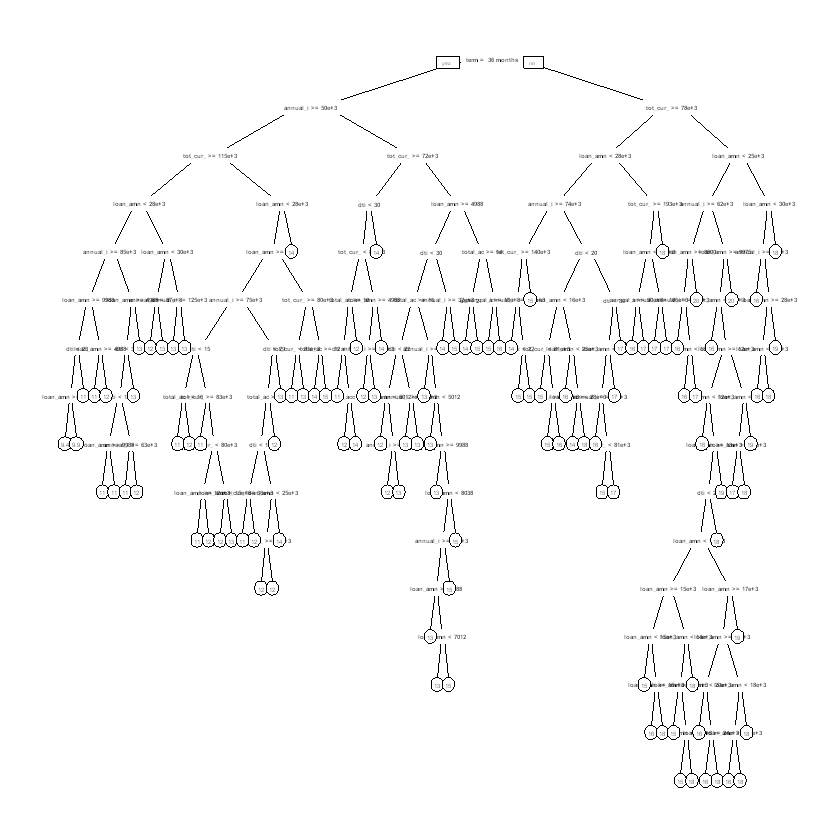

In [89]:
prp(tree.pruned, faclen = 0, cex = 0.3)
# http://www.milbo.org/rpart-plot/prp.pdf
# cex is the text size, faclen is the length of factor level names in splits.

# random forest

In [90]:
library(randomForest)

Warning message:
"package 'randomForest' was built under R version 3.4.3"randomForest 4.6-12
Type rfNews() to see new features/changes/bug fixes.


In [91]:
# Categorical featues need to be factors when using randomForest
train.sub$state_mean_int <- as.factor(train.sub$state_mean_int)
train.sub$home_ownership <- as.factor(train.sub$home_ownership)
train.sub$term <- as.factor(train.sub$term)

In [92]:
set.seed(2)
# Potential error in randomForest formula: https://stackoverflow.com/questions/10318560/constructing-the-formula-for-randomforest-classification-and-then-using-predict
# Note that rf doesn't take missing value like rpart.

# what if random forest is too slow: https://stackoverflow.com/questions/23075506/how-to-improve-randomforest-performance
# another thread: https://stats.stackexchange.com/questions/37370/random-forest-computing-time-in-r
rf <- randomForest(x = train.sub[, -1], y = train.sub[, 1], importance = TRUE,
                   do.trace = TRUE, nodesize = 6200, ntree = 10)

     |      Out-of-bag   |
Tree |      MSE  %Var(y) |
   1 |    14.84    77.24 |
   2 |    14.57    75.87 |
   3 |     14.5    75.48 |
   4 |    14.45    75.24 |
   5 |    14.37    74.83 |
   6 |    14.33    74.61 |
   7 |    14.31    74.52 |
   8 |    14.29    74.41 |
   9 |    14.31    74.47 |
  10 |    14.29    74.38 |


In [95]:
getTree(rf, k = 1, labelVar = TRUE) # output tree 1 for example with variable labeled

left daughter,right daughter,split var,split point,status,prediction
2,3,home_ownership,1.000,-3,13.23695
4,5,dti,19.675,-3,12.97387
6,7,loan_amnt,28037.500,-3,13.50003
8,9,tot_cur_bal,74240.500,-3,12.44539
10,11,loan_amnt,28012.500,-3,13.74992
12,13,term,1.000,-3,13.36564
14,15,loan_amnt,30012.500,-3,15.81707
16,17,loan_amnt,20012.500,-3,13.17279
18,19,loan_amnt,28037.500,-3,12.29540
20,21,term,1.000,-3,13.48353


In [94]:
par(mar=rep(2,4)) # change margin in plot setting.

In [96]:
par()$mfrow

[1] 1 1

In [97]:
par(mfrow = c(1,1))

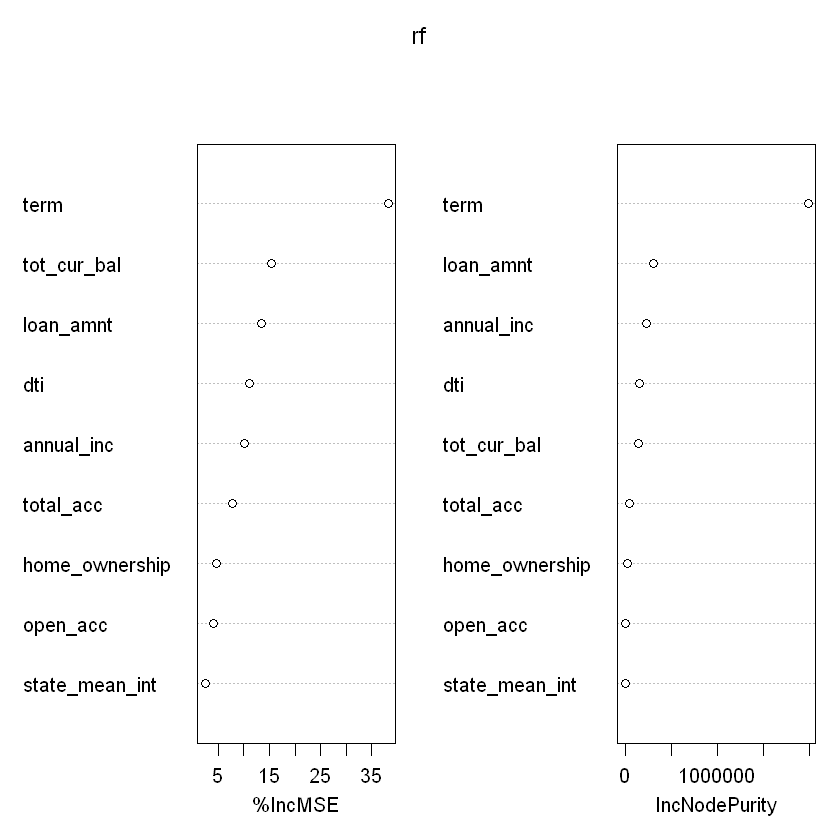

In [98]:
varImpPlot(rf)
# %IncMSE shows if a variable is assigned values by random permutation, how much will the MSE increase?
# 1 train forest
# 2 measure out-of-bag accuracy -> OOB_acc_base
# 3 permute variable i
# 4 measure out-of-bag accuracy -> OOB_acc_perm_i
# 5 VI_i = - (OOB_acc_perm_i - OOB_acc_base)
# So Higher the value, higher the variable importance.
# IncNodePurity is measured by the difference between sum of squared error before and after the split on that variable.


In [100]:
importance(rf, type = 1) # 2)
# Both accuracy tests to see how worse the model performs without each variable
# The Gini one digs into the mathematics behind decision trees, 
# but essentially measures how pure the nodes are at the end of the tree. 

,%IncMSE
state_mean_int,2.416181
home_ownership,4.674701
annual_inc,10.171442
dti,11.095985
term,38.292150
loan_amnt,13.355307
total_acc,7.777054
tot_cur_bal,15.343490
open_acc,4.091903


In [101]:
importanceOrder= order(rf$importance[, "%IncMSE"], decreasing = T)

In [102]:
names=rownames(rf$importance)[importanceOrder]

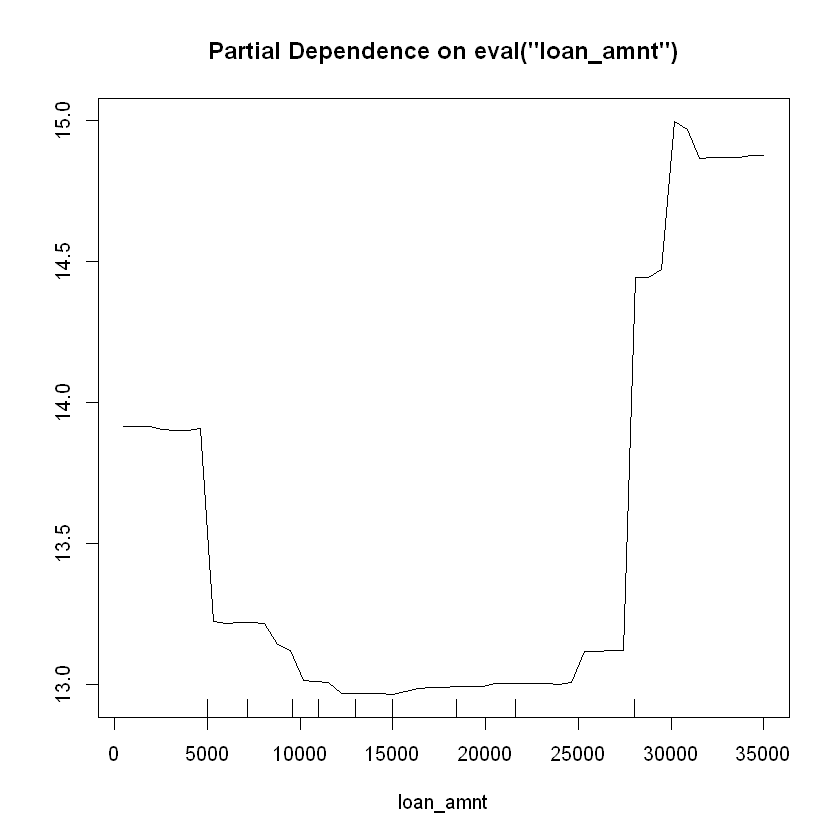

In [103]:
# partialPlot is interpreted as the predicted value for a particular value of an explanatory variable
# averaged across the observed values of the other predictors. 
# https://cran.r-project.org/web/packages/datarobot/vignettes/PartialDependence.html
# http://zmjones.com/static/papers/rfss_manuscript.pdf
partialPlot(rf, train.sub, eval('loan_amnt'), xlab='loan_amnt')


Warning message:
"package 'tabplot' was built under R version 3.4.3"Loading required package: bit
Attaching package bit
package:bit (c) 2008-2012 Jens Oehlschlaegel (GPL-2)
creators: bit bitwhich
coercion: as.logical as.integer as.bit as.bitwhich which
operator: ! & | xor != ==
querying: print length any all min max range sum summary
bit access: length<- [ [<- [[ [[<-
for more help type ?bit

Attaching package: 'bit'

The following object is masked from 'package:base':

    xor

Loading required package: ff
Warning message:
"package 'ff' was built under R version 3.4.3"Attaching package ff
- getOption("fftempdir")=="C:/Users/yuanq/AppData/Local/Temp/RtmpwpyMDC"

- getOption("ffextension")=="ff"

- getOption("ffdrop")==TRUE

- getOption("fffinonexit")==TRUE

- getOption("ffpagesize")==65536

- getOption("ffcaching")=="mmnoflush"  -- consider "ffeachflush" if your system stalls on large writes

- getOption("ffbatchbytes")==170519429.12 -- consider a different value for tuning your system

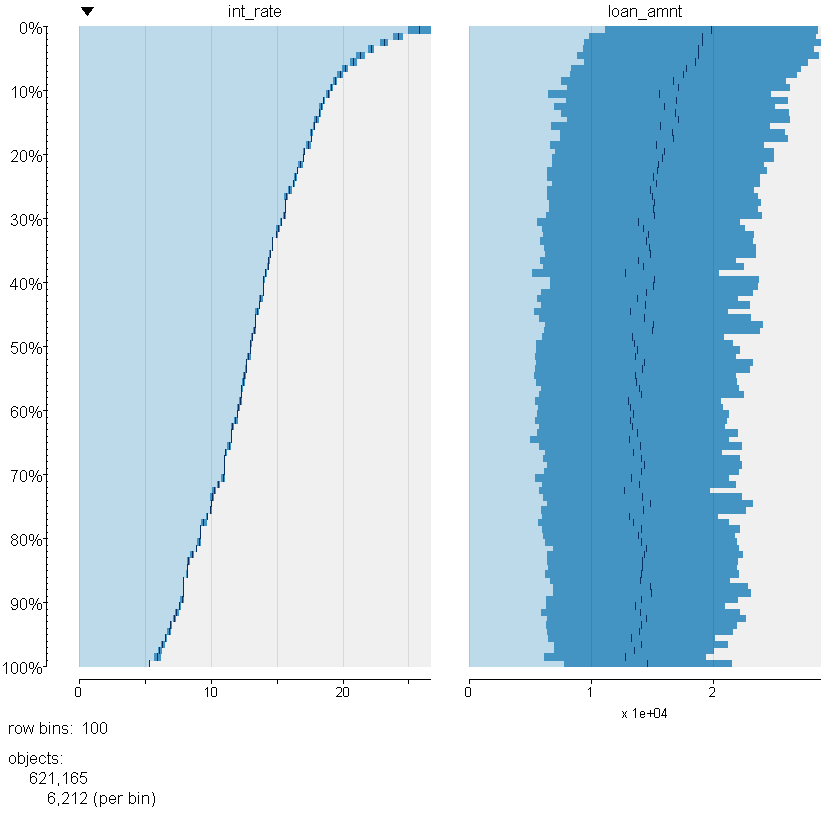

In [104]:
library(tabplot)
tableplot(train, c('int_rate', 'loan_amnt'), scales = 'lin')
# Verify the relationships between feature and response


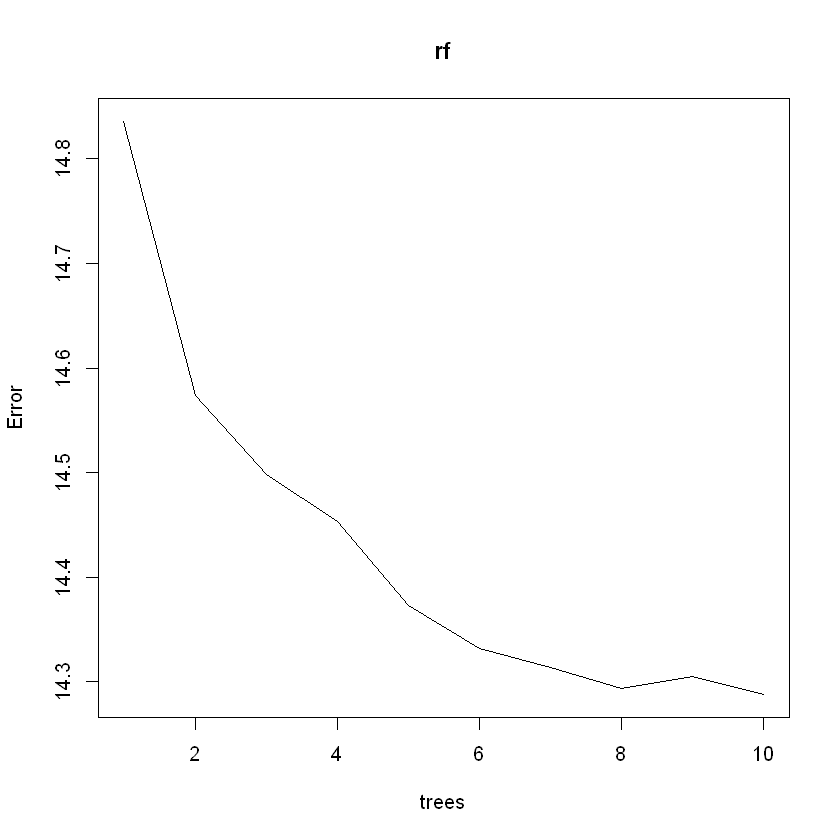

In [105]:
plot(rf) # see oob error
# Black solid line for overall OOB error. If classification problem, see a bunch of colour lines, one for each class' error
# Can rf get overfitting? Yes.
# Solution: there is also RRF library, or control for how deep the tree could grow,
# say nodesize (Minimum size of terminal nodes) and maxnodes(Maximum number of terminal nodes trees)


In [106]:
test$state_mean_int <- as.factor(test$state_mean_int)
test$home_ownership <- as.factor(test$home_ownership)
test$term <- as.factor(test$term)
test.pred <- predict(rf, test)
sqrt(sum((test.pred - test$int_rate)^2) / dim(test)[1]) # 3.76


[1] 3.76178

# xgboost

In [110]:
install.packages("xgboost",repos="http://cran.rstudio.com/")

Installing package into 'C:/Users/yuanq/Documents/R/win-library/3.4'
(as 'lib' is unspecified)


package 'xgboost' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\yuanq\AppData\Local\Temp\RtmpwpyMDC\downloaded_packages


In [111]:
# http://xgboost.readthedocs.io/en/latest/
library(xgboost) 

Warning message:
"package 'xgboost' was built under R version 3.4.3"

In [112]:
train.label <- train.sub$int_rate

In [113]:
# Xgboost manages only numeric vectors.
feature.matrix <- model.matrix( ~ ., data = train.sub[, -1]) 
# Remember we removed rows with NA in randomForest fitting. model.matrix will also remove rows with any NA.


In [114]:
set.seed(1)
gbt <- xgboost(data =  feature.matrix, 
               label = train.label, 
               max_depth = 8, # for each tree, how deep it goes
               nround = 20, # number of trees
               objective = "reg:linear",
               nthread = 3,
               verbose = 1)

[1]	train-rmse:9.807165 
[2]	train-rmse:7.365797 
[3]	train-rmse:5.801589 
[4]	train-rmse:4.848780 
[5]	train-rmse:4.303016 
[6]	train-rmse:4.003619 
[7]	train-rmse:3.844494 
[8]	train-rmse:3.761524 
[9]	train-rmse:3.701499 
[10]	train-rmse:3.676217 
[11]	train-rmse:3.662384 
[12]	train-rmse:3.652248 
[13]	train-rmse:3.641464 
[14]	train-rmse:3.630863 
[15]	train-rmse:3.624336 
[16]	train-rmse:3.621969 
[17]	train-rmse:3.614285 
[18]	train-rmse:3.607068 
[19]	train-rmse:3.596910 
[20]	train-rmse:3.594233 


In [115]:
importance <- xgb.importance(feature_names = colnames(feature.matrix), model = gbt)
importance
# Gain: contribution of each feature to the model. improvement in accuracy brought by a feature to the branches it is on.
#       For boosted tree model, gain of each feature in each branch of each tree is taken into account, 
#       then average per feature to give a vision of the entire model.
#       Highest percentage means important feature to predict the label used for the training.
# Cover: the number of observation through a branch using this feature as split feature 
# Frequency: counts the number of times a feature is used in all generated trees (often we don't use it).


Feature,Gain,Cover,Frequency
term 60 months,0.5663950956,0.0754984889,0.0081213935
loan_amnt,0.1770358997,0.4478050132,0.2714255183
annual_inc,0.1145288312,0.0837525388,0.1765334473
tot_cur_bal,0.0629928753,0.0817434303,0.1664885659
dti,0.0395444820,0.1009044677,0.1555888010
total_acc,0.0208779347,0.0894951855,0.0961743962
open_acc,0.0107882865,0.0417302411,0.0760846335
home_ownershipRENT,0.0053537933,0.0267400366,0.0143192990
state_mean_intlow,0.0013572045,0.0246673574,0.0126095320
home_ownershipOWN,0.0005449505,0.0102570289,0.0066253473


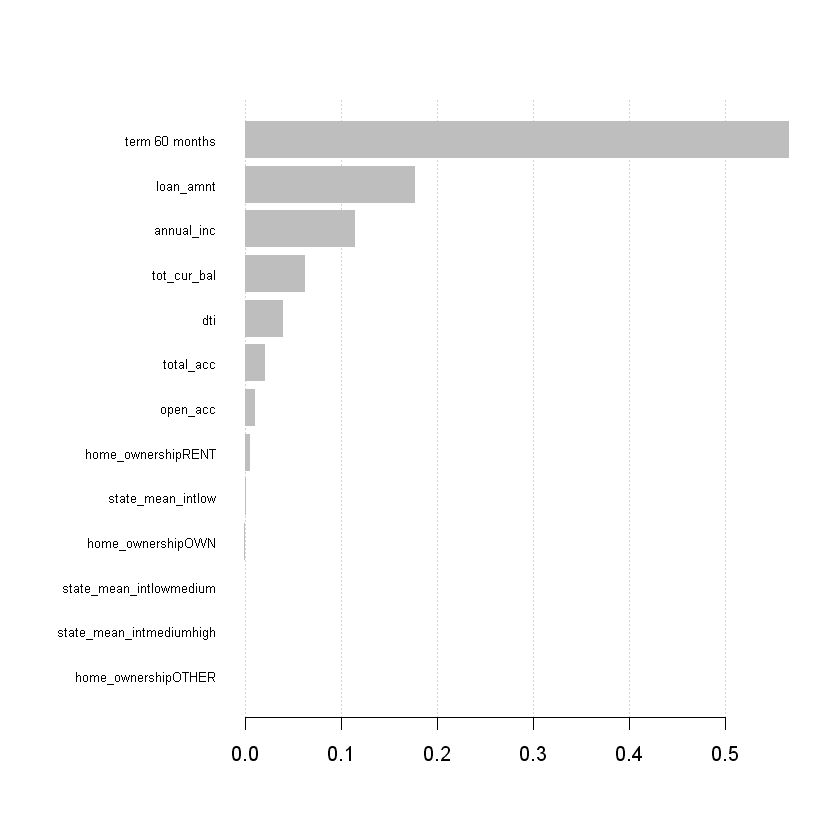

In [116]:
xgb.plot.importance(importance)

### Xgboost Cross Validation

In [117]:
# what's the optimal parameter, for example, number of trees?
par <- list( max_depth = 8,
             objective = "reg:linear",
             nthread = 3,
             verbose = 2)

In [118]:
gbt.cv <- xgb.cv(params = par,
                 data = feature.matrix, label = train.label,
                 nfold = 5, nrounds = 30)
# gbt.cv is to choose best nrounds based on certain parameters set. 
# Because, too small nrounds is underfitting, and too large nrounds is overfitting
# But what about the other parameters? 
# See: http://stackoverflow.com/questions/35050846/xgboost-in-r-how-does-xgb-cv-pass-the-optimal-parameters-into-xgb-train

[1]	train-rmse:9.807069+0.002364	test-rmse:9.808603+0.012249 
[2]	train-rmse:7.365606+0.001636	test-rmse:7.369488+0.011477 
[3]	train-rmse:5.800815+0.001259	test-rmse:5.807940+0.010463 
[4]	train-rmse:4.847906+0.001719	test-rmse:4.859129+0.008920 
[5]	train-rmse:4.299030+0.000566	test-rmse:4.314387+0.008613 
[6]	train-rmse:3.998244+0.002576	test-rmse:4.017383+0.005648 
[7]	train-rmse:3.838497+0.002444	test-rmse:3.861075+0.004585 
[8]	train-rmse:3.752589+0.002679	test-rmse:3.778756+0.005076 
[9]	train-rmse:3.703546+0.003901	test-rmse:3.732603+0.005198 
[10]	train-rmse:3.677055+0.004258	test-rmse:3.709206+0.004740 
[11]	train-rmse:3.657592+0.004554	test-rmse:3.692552+0.002105 
[12]	train-rmse:3.645965+0.003637	test-rmse:3.683337+0.003755 
[13]	train-rmse:3.637404+0.003620	test-rmse:3.677034+0.003804 
[14]	train-rmse:3.629142+0.002966	test-rmse:3.671241+0.005201 
[15]	train-rmse:3.621446+0.002999	test-rmse:3.666217+0.005131 
[16]	train-rmse:3.615659+0.003767	test-rmse:3.662311+0.005039 
[

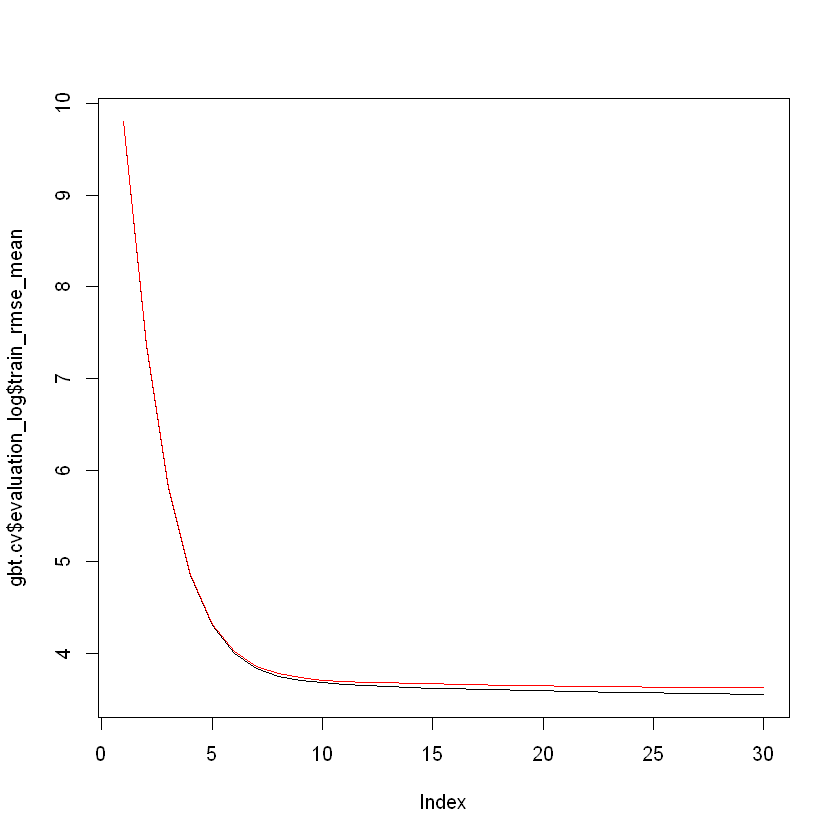

In [119]:
plot(gbt.cv$evaluation_log$train_rmse_mean, type = 'l')
lines(gbt.cv$evaluation_log$test_rmse_mean, col = 'red')
nround = which(gbt.cv$evaluation_log$test_rmse_mean == 
                 min(gbt.cv$evaluation_log$test_rmse_mean)) # 11

In [120]:
gbt <- xgboost(data = feature.matrix, 
               label = train.label,
               nround = nround,
               params = par)

[1]	train-rmse:9.807165 
[2]	train-rmse:7.365797 
[3]	train-rmse:5.801589 
[4]	train-rmse:4.848780 
[5]	train-rmse:4.303016 
[6]	train-rmse:4.003619 
[7]	train-rmse:3.844494 
[8]	train-rmse:3.761524 
[9]	train-rmse:3.701499 
[10]	train-rmse:3.676217 
[11]	train-rmse:3.662384 
[12]	train-rmse:3.652248 
[13]	train-rmse:3.641464 
[14]	train-rmse:3.630863 
[15]	train-rmse:3.624336 
[16]	train-rmse:3.621969 
[17]	train-rmse:3.614285 
[18]	train-rmse:3.607068 
[19]	train-rmse:3.596910 
[20]	train-rmse:3.594233 
[21]	train-rmse:3.589939 
[22]	train-rmse:3.586419 
[23]	train-rmse:3.582021 
[24]	train-rmse:3.581053 
[25]	train-rmse:3.576816 
[26]	train-rmse:3.572793 
[27]	train-rmse:3.569757 
[28]	train-rmse:3.564205 
[29]	train-rmse:3.558230 
[30]	train-rmse:3.553372 


# Grid Search

In [122]:
# grid searching for parameters.
all_param = NULL
all_test_rmse = NULL
all_train_rmse = NULL

for (iter in 1:20) {
  print(iter)
  param <- list(objective = "reg:linear",
                max_depth = sample(5:12, 1), 
                subsample = runif(1, .6, .9)
                #   eta = runif(1, .01, .3)
                #  gamma = runif(1, 0.0, 0.2),
                #  colsample_bytree = runif(1, .5, .8), 
                #  min_child_weight = sample(1:40, 1),
                #  max_delta_step = sample(1:10, 1)
  )
  cv.nround = 10
  cv.nfold = 5
  set.seed(iter)
  mdcv <- xgb.cv(data=feature.matrix, label = train.label, params = param, 
                 nfold=cv.nfold, nrounds=cv.nround,
                 verbose = T, # early_stop_round=8, 
                 maximize = FALSE)  
      min_train_rmse = min(mdcv$evaluation_log$train_rmse_mean)
  min_test_rmse = min(mdcv$evaluation_log$test_rmse_mean)
  
  all_param <- rbind(all_param, unlist(param)[-1])
  all_train_rmse <- c(all_train_rmse, min_train_rmse)
  all_test_rmse <- c(all_test_rmse, min_test_rmse)
}

[1] 1
[1]	train-rmse:9.817767+0.003051	test-rmse:9.818033+0.010089 
[2]	train-rmse:7.387181+0.003005	test-rmse:7.387747+0.009997 
[3]	train-rmse:5.832599+0.002852	test-rmse:5.833819+0.009493 
[4]	train-rmse:4.889822+0.002792	test-rmse:4.891550+0.008967 
[5]	train-rmse:4.350292+0.002388	test-rmse:4.352513+0.008320 
[6]	train-rmse:4.056239+0.001829	test-rmse:4.058877+0.008046 
[7]	train-rmse:3.901347+0.002011	test-rmse:3.904314+0.007096 
[8]	train-rmse:3.819969+0.002504	test-rmse:3.823381+0.005390 
[9]	train-rmse:3.777803+0.002106	test-rmse:3.781589+0.005332 
[10]	train-rmse:3.754124+0.001720	test-rmse:3.758382+0.005261 
[1] 2
[1]	train-rmse:9.804418+0.001228	test-rmse:9.807945+0.006465 
[2]	train-rmse:7.357882+0.001631	test-rmse:7.369086+0.006060 
[3]	train-rmse:5.782833+0.001854	test-rmse:5.806371+0.006064 
[4]	train-rmse:4.815854+0.001259	test-rmse:4.855451+0.007339 
[5]	train-rmse:4.250848+0.002347	test-rmse:4.306498+0.008733 
[6]	train-rmse:3.935313+0.002121	test-rmse:4.006799+0.006

In [123]:
all_param <- as.data.frame(as.numeric(all_param))
cbind(all_param, all_test_rmse)

as.numeric(all_param),all_test_rmse
5.0000000,3.758382
11.0000000,3.699305
6.0000000,3.738291
11.0000000,3.694815
9.0000000,3.698446
12.0000000,3.696679
12.0000000,3.690712
5.0000000,3.758402
12.0000000,3.691858
6.0000000,3.736078


In [124]:
summary(all_test_rmse[which(all_param == 5)])

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  3.757   3.758   3.758   3.758   3.758   3.758 

In [125]:
summary(all_test_rmse[which(all_param == 12)])

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  3.691   3.692   3.694   3.695   3.697   3.699 

In [126]:
# then build the model with best parameter combination from the cross validation result.

In [ ]:
# prediction
test.data <- test.data[which(apply(test.data, 1, 
                                   function(x) length(which(is.na(x))) == 0)), ]

In [ ]:
prediction <- predict(gbt, model.matrix( ~ ., data = test.data[, feat.cols]))

In [ ]:
sum((prediction - test.data$logerror)^2)/dim(test.data)[1]

In [ ]:
sum((predict(tree1, test.data) - test.data$logerror)^2)/dim(test.data)[1]

In [ ]:
sum((predict(rf, test.data) - test.data$logerror)^2)/dim(test.data)[1]

In [ ]:
sum((predict(lm(formula, train.data), test.data) - test.data$logerror)^2)/dim(test.data)[1]